Final Project: Display Advertising Challenge
========================

Team 25: Michael Zeng, Param Viswanathan, Gopinath Duddi, Hailey Wu

# Abstract

Prediction for click-through rate (CTR) is critical for target advertisement in order to drive purchase interests with the right content displayed. With more and more session or user specific cookies, data scientists now have more information to analyze on, but also need to take consideration of sensitive data. This report attempts to predict the CTR with multiple machine learning approaches based on the Criteo Labs' Kaggle Display Advertising Challenge dataset. Large effort involves data understanding, engineering and scalable processing. Using the best logistic regression model we trained, the lowest log loss reaches 0.50 on the test data.



# Question Formulation

* The goal of this project is to predict the click-through rate on the advertising based on a variety of features collected. 

* The empirical relationship between the observablem features and the efficiency of the advertisement distribution that this research is trying to establish will be extremely valuable to a lot of businesses. 



As a billion dollar effort driven industry, target advertisement has long been the research focus to enhance the accuracy for the right content at the right time for the right group of viewers. Many machine learning models are built to understand the probability of a given user to click on a displayed advertisement, as called the prediction of click-through rate (CTR). With increasing footprint cookies on the Internet, marketing companies now have more user-specific information that can be fed into the models. Coming along with the benefit of user details, data scientists face new challenges. One concern is how to process efficiency With the massive data, under time and budget constraints, while the other is how to use the less comprehensible personal data under private information protection.

This study aims to use the user data provided by Criteo Labs' Kaggle Display Advertising Challenge to predict advertisement click-through rate. This two-class problem is approached with various machine learning models, mostly logistic regression and gradient boosted trees after trials. The work contains exploratory data analysis, feature engineering, feature selection, pipeline development and model tuning. Specifically, with unnamed integer and hashed categorical variables, the team puts main effort into interpreting and transforming the data that will reduce the log loss. With the massive data, the team takes a random 100,000 samples for model development, and runs the final model with parquet format, Spark dataframe type, and Spark MLLib on GCP engine (input the GCP engine information). With all attempts, the study tries to answer the question:

**"Given a user and the page he or she is visiting, what is the probability that he will click on a given ad?"**

The team considers the two real-life challenges for display advertisement while developing the model. The study uses log loss as the metric with limitation of the given background. With the prediction of CTR, companies can further look into the sale conversion rate and define a more specific metric to enhance the profit-driven model.

There are unique challenges to this problem:
1. The sheer size of the data makes it unsuitable for the typical tools people use for modeling, such as Pandas and SKlearn, which is why we choose to do it with Spark MLlib. 
2. The complexity of the features space would normally require a lot of domain knowledge, yet here the data is presented anonymously. Therefore, the research presented in this notebook will be based on statistical observations and practices. 
3. While researching into the problem, our team also keeps in mind the needs of real-time production. And that's why we have built Spark pipelines for the data, and depending on the business needs, we could efficiently deploy the code for updates/retrain of the model.

Yet, such unique problem setup also has certain benefits:
1. The data is not so imbalanced, which makes it suitable for a larger set of algorithms, unlike data for predicting credit card default which is generally imbalanced.
2. The lack of timestamps also frees us from considerations of time series property of our model and its predictions. 
3. The problem itself allows bigger margin of error and is not so demanding on the intuitiveness of the model. Meaning the business wouldn't really grill us if we got one or two predictions wrong, nor are they likely to demand that we "open the box" for them and explain exactly what went into the prediction on any given case. This also opens up more freedom for us in terms of features engineering and model selection. 


# Download Data 

## Download the small dataset from Kaggle
The following cell is run in the conda environement that we used to submit jobs to clusters. You might need to install the kaggle module `kaggle` by `!pip install kaggle`, and go through the authentications and accept term of use. 

In [51]:
import os
# os.chdir('/Users/zengm71/Documents/Berkeley/W261/f19-final-project-f19-team-25/')
!kaggle competitions download -c criteo-display-ad-challenge -p small_data/

 99%|█████████████████████████████████████▌| 47.0M/47.6M [00:02<00:00, 22.9MB/s]
100%|██████████████████████████████████████| 47.6M/47.6M [00:02<00:00, 21.9MB/s]


In [54]:
import zipfile
zipfile.ZipFile('small_data/criteo-display-ad-challenge.zip', 'r').\
        extractall('small_data/')
zipfile.ZipFile('small_data/random_submission.zip', 'r').\
        extractall('small_data/')

!rm small_data/criteo-display-ad-challenge.zip
!rm small_data/random_submission.zip

## Download the full data set

In [2]:
!curl -O https://s3-eu-west-1.amazonaws.com/kaggle-display-advertising-challenge-dataset/dac.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4364M  100 4364M    0     0  21.2M      0  0:03:25  0:03:25 --:--:-- 21.5M


In [3]:
!mkdir full_data
!tar -xvzf dac.tar.gz -C full_data/
!rm dac.tar.gz

tar: Ignoring unknown extended header keyword `SCHILY.dev'
tar: Ignoring unknown extended header keyword `SCHILY.ino'
tar: Ignoring unknown extended header keyword `SCHILY.nlink'
readme.txt
tar: Ignoring unknown extended header keyword `LIBARCHIVE.creationtime'
tar: Ignoring unknown extended header keyword `SCHILY.dev'
tar: Ignoring unknown extended header keyword `SCHILY.ino'
tar: Ignoring unknown extended header keyword `SCHILY.nlink'
test.txt
tar: Ignoring unknown extended header keyword `SCHILY.dev'
tar: Ignoring unknown extended header keyword `SCHILY.ino'
tar: Ignoring unknown extended header keyword `SCHILY.nlink'
train.txt


In [1]:
# imports
import re
import ast
import time
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import Row
%matplotlib inline

In [2]:
# set up spark 
%reload_ext autoreload
%autoreload 2
# store path to notebook
PWD = !pwd
PWD = PWD[0]
# start Spark Session
from pyspark.sql import SparkSession
app_name = "final_project"
master = "local[*]"
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .master(master)\
        .config('spark.executor.memory', '12g')\
        .getOrCreate()
# from pyspark import SparkContext
# SparkContext.setSystemProperty('spark.executor.memory', '15g')
sc = spark.sparkContext
spark

## Read into dataframe

In [10]:
# Read the text file in with RDD
# the categoricals can be read in as they are. 
# Since the numerics are all integers, we add '0' to the end and divide by 10

df = sc.textFile('full_data/train.txt').\
        map(lambda l: l.split("\t")).\
        map(lambda p: Row(label=int(p[0]), 
                          c01 = int(p[1] + '0') / 10, c02 = int(p[2] + '0') / 10, c03 = int(p[3] + '0') / 10, c04 = int(p[4] + '0') / 10, c05 = int(p[5] + '0') / 10, c06 = int(p[6] + '0') / 10, 
                          c07 = int(p[7] + '0') / 10, c08 = int(p[8] + '0') / 10, c09 = int(p[9] + '0') / 10, c10 = int(p[10] + '0') / 10, c11 = int(p[11] + '0') / 10, c12 = int(p[12] + '0') / 10, 
                          c13 = int(p[13] + '0') / 10, 
                          b01 = p[14], b02 = p[15], b03 = p[16], b04 = p[17], b05 = p[18], b06 = p[19], b07 = p[20], b08 = p[21], b09 = p[22], b10 = p[23], b11 = p[24], b12 = p[25], b13 = p[26], 
                          b14 = p[27], b15 = p[28], b16 = p[29], b17 = p[30], b18 = p[31], b19 = p[32], b20 = p[33], b21 = p[34], b22 = p[35], b23 = p[36], b24 = p[37], b25 = p[38], b26 = p[39], ))

# Infer the schema, and register the DataFrame as a table.
schema_df = spark.createDataFrame(df)
schema_df.createOrReplaceTempView("df")


Print out just a few columns:

In [11]:
schema_df.select('c01', 'c02', 'c03', 'b01', 'b02', 'b03', 'label').show()

+---+-----+-----+--------+--------+--------+-----+
|c01|  c02|  c03|     b01|     b02|     b03|label|
+---+-----+-----+--------+--------+--------+-----+
|1.0|  1.0|  5.0|68fd1e64|80e26c9b|fb936136|    0|
|2.0|  0.0| 44.0|68fd1e64|f0cf0024|6f67f7e5|    0|
|2.0|  0.0|  1.0|287e684f|0a519c5c|02cf9876|    0|
|0.0|893.0|  0.0|68fd1e64|2c16a946|a9a87e68|    0|
|3.0| -1.0|  0.0|8cf07265|ae46a29d|c81688bb|    0|
|0.0| -1.0|  0.0|05db9164|6c9c9cf3|2730ec9c|    0|
|0.0|  1.0|  2.0|439a44a4|ad4527a2|c02372d0|    0|
|1.0|  4.0|  2.0|68fd1e64|2c16a946|503b9dbc|    1|
|0.0| 44.0|  4.0|05db9164|d833535f|d032c263|    0|
|0.0| 35.0|  0.0|05db9164|510b40a5|d03e7c24|    0|
|0.0|  2.0|632.0|05db9164|0468d672|7ae80d0f|    0|
|0.0|  6.0|  6.0|05db9164|9b5fd12f|        |    0|
|0.0| -1.0|  0.0|241546e0|38a947a1|fa673455|    1|
|0.0|  2.0| 11.0|be589b51|287130e0|cd7a7a22|    1|
|0.0| 51.0| 84.0|5a9ed9b0|80e26c9b|97144401|    0|
|0.0|  2.0|  1.0|05db9164|bc6e3dc1|67799c69|    0|
|1.0|987.0|  0.0|68fd1e64|38d50

The 3-bit hashed columns have different number of distinct values, so I will just leave the hash code as it is right now:

In [12]:
schema_df.printSchema()

root
 |-- b01: string (nullable = true)
 |-- b02: string (nullable = true)
 |-- b03: string (nullable = true)
 |-- b04: string (nullable = true)
 |-- b05: string (nullable = true)
 |-- b06: string (nullable = true)
 |-- b07: string (nullable = true)
 |-- b08: string (nullable = true)
 |-- b09: string (nullable = true)
 |-- b10: string (nullable = true)
 |-- b11: string (nullable = true)
 |-- b12: string (nullable = true)
 |-- b13: string (nullable = true)
 |-- b14: string (nullable = true)
 |-- b15: string (nullable = true)
 |-- b16: string (nullable = true)
 |-- b17: string (nullable = true)
 |-- b18: string (nullable = true)
 |-- b19: string (nullable = true)
 |-- b20: string (nullable = true)
 |-- b21: string (nullable = true)
 |-- b22: string (nullable = true)
 |-- b23: string (nullable = true)
 |-- b24: string (nullable = true)
 |-- b25: string (nullable = true)
 |-- b26: string (nullable = true)
 |-- c01: double (nullable = true)
 |-- c02: double (nullable = true)
 |-- c03: doubl

In [13]:
# the distribution of features are a bit imbalanced, but not extremely skewed
schema_df.groupBy('label').count().show()

+-----+--------+
|label|   count|
+-----+--------+
|    0|34095179|
|    1|11745438|
+-----+--------+



## Write to parquet, because it makes everything a lot faster. Thanks James!

In [ ]:
schema_df.write.parquet("full_data/train.parquet")

In [3]:
parquet_df = spark.read.parquet("full_data/train.parquet")

# Parquet files can also be used to create a temporary view and then used in SQL statements.
parquet_df.createOrReplaceTempView("parquet_df")
parquet_df.printSchema()

root
 |-- b01: string (nullable = true)
 |-- b02: string (nullable = true)
 |-- b03: string (nullable = true)
 |-- b04: string (nullable = true)
 |-- b05: string (nullable = true)
 |-- b06: string (nullable = true)
 |-- b07: string (nullable = true)
 |-- b08: string (nullable = true)
 |-- b09: string (nullable = true)
 |-- b10: string (nullable = true)
 |-- b11: string (nullable = true)
 |-- b12: string (nullable = true)
 |-- b13: string (nullable = true)
 |-- b14: string (nullable = true)
 |-- b15: string (nullable = true)
 |-- b16: string (nullable = true)
 |-- b17: string (nullable = true)
 |-- b18: string (nullable = true)
 |-- b19: string (nullable = true)
 |-- b20: string (nullable = true)
 |-- b21: string (nullable = true)
 |-- b22: string (nullable = true)
 |-- b23: string (nullable = true)
 |-- b24: string (nullable = true)
 |-- b25: string (nullable = true)
 |-- b26: string (nullable = true)
 |-- c01: double (nullable = true)
 |-- c02: double (nullable = true)
 |-- c03: doubl

## Sample out a small dataframe for EDA

In [4]:
# sample out 100k rows for the EDA and toy examples
sample_df = parquet_df.sample(fraction=100000/(34095179 + 11745438), seed=8888).cache()

Turns out there is some floating value outflow in the sample, we got 100085 rows. But that should be OK for the purpose of some EDA and visualization. 

In [5]:
sample_df.count()

100085

In [6]:
sample_df.take(5)

[Row(b01='5a9ed9b0', b02='80e26c9b', b03='51546964', b04='745c6c18', b05='4cf72387', b06='', b07='1b2007fe', b08='0b153874', b09='a73ee510', b10='f9065d00', b11='6c07e306', b12='179a11e3', b13='1cd94349', b14='b28479f6', b15='4c1df281', b16='4bcf344c', b17='1e88c74f', b18='f54016b9', b19='21ddcdc9', b20='5840adea', b21='2d1f75c0', b22='', b23='32c7478e', b24='b0fb6a50', b25='e8b83407', b26='61556511', c01=0.0, c02=-1.0, c03=0.0, c04=0.0, c05=1475.0, c06=0.0, c07=0.0, c08=22.0, c09=25.0, c10=0.0, c11=0.0, c12=0.0, c13=0.0, label=0),
 Row(b01='05db9164', b02='68aede49', b03='dabd54b8', b04='c2268dde', b05='25c83c98', b06='7e0ccccf', b07='5e64ce5f', b08='5b392875', b09='a73ee510', b10='afd9b8fe', b11='8b94178b', b12='62231334', b13='025225f2', b14='b28479f6', b15='5c595008', b16='9aa05cbb', b17='e5ba7672', b18='262c8681', b19='', b20='', b21='a2bb9a62', b22='', b23='32c7478e', b24='2f4c59f7', b25='', b26='', c01=0.0, c02=1.0, c03=1.0, c04=0.0, c05=1591.0, c06=0.0, c07=0.0, c08=4.0, c09=4.

In [7]:
# write to csv to consume later
sample_df.repartition(1).write.csv(path='full_data/sample.csv', mode="append", header="true")

In [8]:
# read to pandsa
sample_df_pd = sample_df.toPandas()

In [9]:
# create a copy for Breiman's method, since it will follow a very different waterfall
sample_df_bm = sample_df

# Algorithm explanation

In this section, we try to implement logistic regression using RDD with the sampled data (`sample_df`). To make the calculation easier, we picked the first numeric column `c01`, a categorical column `b09` with the least number of unique categories, and the top 100 rows to form a toy RDD dataset. 

* Logistic Regression
    - Setup: $$p(y = 1) = \frac{1}{1+exp(-wX)}$$
    - Objective function: $$L = \frac{1}{m}\sum_{i=1}^m y_i\cdot log(p(y_i = 1))+ (1-y_i)\cdot log(1- p(y_i = 1))$$
    - Gradient:$$J = \frac{1}{m} \sum_{i=1}^m (y_i-p(y_i = 1))x_i$$

In [15]:
# head of sample_df_toy
sample_df_toy = sample_df.select("c01", "b09", "label").limit(100)
sample_df_toy.show(5)

+---+--------+-----+
|c01|     b09|label|
+---+--------+-----+
|0.0|a73ee510|    0|
|0.0|a73ee510|    0|
|0.0|a73ee510|    0|
|1.0|a73ee510|    0|
|0.0|a73ee510|    1|
+---+--------+-----+
only showing top 5 rows



In [16]:
# distribution of labels, it is close to the full dataset
sample_df_toy.groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|    0|   73|
|    1|   27|
+-----+-----+



* Transform the continuous variable with log1p:

In [17]:
# the original disttribution is skewed, but since it is non-negative, log1p is a suitable transformation
sample_df_toy.select('c01').describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
c01,100,1.56,4.23148372860567,0.0,25.0


In [18]:
# log1p transoformation, after which the scales are more compact. 
from pyspark.sql.functions import when, log1p, col
sample_df_toy = sample_df_toy.withColumn('c01_t', log1p('c01'))
sample_df_toy.show(5)
sample_df_toy.select('c01_t').describe().toPandas().transpose()

+---+--------+-----+------------------+
|c01|     b09|label|             c01_t|
+---+--------+-----+------------------+
|0.0|a73ee510|    0|               0.0|
|0.0|a73ee510|    0|               0.0|
|0.0|a73ee510|    0|               0.0|
|1.0|a73ee510|    0|0.6931471805599453|
|0.0|a73ee510|    1|               0.0|
+---+--------+-----+------------------+
only showing top 5 rows



,0,1,2,3,4
summary,count,mean,stddev,min,max
c01_t,100,0.429320903037294,0.8011288879342549,0.0,3.258096538021482


* Standardize the transformed c01:

In [19]:
# we'd de-mean and divide by standard deviation
# after that the column is mean 0 with stdev 1
sample_df_toy = sample_df_toy.withColumn('c01_ts', (col('c01_t') - 0.429320903037294)/0.8011288879342549)
sample_df_toy.show(5)
sample_df_toy.select('c01_ts').describe().toPandas().transpose()

+---+--------+-----+------------------+------------------+
|c01|     b09|label|             c01_t|            c01_ts|
+---+--------+-----+------------------+------------------+
|0.0|a73ee510|    0|               0.0|-0.535894922157053|
|0.0|a73ee510|    0|               0.0|-0.535894922157053|
|0.0|a73ee510|    0|               0.0|-0.535894922157053|
|1.0|a73ee510|    0|0.6931471805599453|0.3293181428058832|
|0.0|a73ee510|    1|               0.0|-0.535894922157053|
+---+--------+-----+------------------+------------------+
only showing top 5 rows



,0,1,2,3,4
summary,count,mean,stddev,min,max
c01_ts,100,7.549516567451065E-17,1.0,-0.535894922157053,3.5309869330493218


* One-hot Encode the categorical variable: here we only have two categories which makes it a lot easier.

In [20]:
# there are two categories originally
sample_df_toy.groupBy('b09').count().show()

+--------+-----+
|     b09|count|
+--------+-----+
|a73ee510|   90|
|7cc72ec2|   10|
+--------+-----+



In [21]:
# one-hot encoding
sample_df_toy = sample_df_toy.withColumn('b09_t1', when(col('b09') == 'a73ee510', 1).otherwise(0))
sample_df_toy.show(10)

+---+--------+-----+------------------+------------------+------+
|c01|     b09|label|             c01_t|            c01_ts|b09_t1|
+---+--------+-----+------------------+------------------+------+
|0.0|a73ee510|    0|               0.0|-0.535894922157053|     1|
|0.0|a73ee510|    0|               0.0|-0.535894922157053|     1|
|0.0|a73ee510|    0|               0.0|-0.535894922157053|     1|
|1.0|a73ee510|    0|0.6931471805599453|0.3293181428058832|     1|
|0.0|a73ee510|    1|               0.0|-0.535894922157053|     1|
|3.0|a73ee510|    1|1.3862943611198906|1.1945312077688193|     1|
|0.0|a73ee510|    0|               0.0|-0.535894922157053|     1|
|0.0|a73ee510|    0|               0.0|-0.535894922157053|     1|
|0.0|a73ee510|    0|               0.0|-0.535894922157053|     1|
|0.0|7cc72ec2|    0|               0.0|-0.535894922157053|     0|
+---+--------+-----+------------------+------------------+------+
only showing top 10 rows



Now implement the gradient descend and logistic regression using RDD. The code largely leveraged the code for linear regression in HW4.

In [22]:
# transform to RDD
sample_df_toy_rdd = sample_df_toy.select('c01_ts', 'b09_t1', 'label')\
                                 .rdd \
                                 .map(lambda x: ([x[0], x[1]], x[2]))
sample_df_toy_rdd.top(5)

[([3.5309869330493218, 1], 1),
 ([3.264395497495463, 1], 0),
 ([3.0719786690064264, 1], 1),
 ([2.844397864544265, 1], 1),
 ([2.7582782993581283, 1], 1)]

In [23]:
# the loss and GDUpdate are adapted from HW4

# part d - write function to compute loss (FILL IN MISSING CODE BELOW)
def Loss(dataRDD, W):
    """
    Compute mean squared error.
    Args:
        dataRDD - each record is a tuple of (features_array, y)
        W       - (array) model coefficients with bias at index 0
    """
    epsilon = 1e-16

    augmentedData = dataRDD.map(lambda x: (np.append([1.0], x[0]), x[1]))
    ################## YOUR CODE HERE ##################
    loss = augmentedData.map(lambda x: -x[1] * np.log(1/(1 + np.exp(- np.dot(x[0], W))) + epsilon)
                                   -(1-x[1]) * np.log(1/(1 + np.exp(np.dot(x[0], W))) + epsilon))\
                        .mean()
    ################## (END) YOUR CODE ##################
    return loss

def GDUpdate(dataRDD, W, learningRate = 0.2):
    """
    Perform one OLS gradient descent step/update.
    Args:
        dataRDD - records are tuples of (features_array, y)
        W       - (array) model coefficients with bias at index 0
    Returns:
        new_model - (array) updated coefficients, bias at index 0
    """
    # add a bias 'feature' of 1 at index 0
    augmentedData = dataRDD.map(lambda x: (np.append([1.0], x[0]), x[1])).cache()
    
    ################## YOUR CODE HERE ################# 
    grad = augmentedData.map(lambda x: (1/(1 + np.exp(-np.dot(W, x[0]))) - x[1]) * x[0]).mean() * 2
    new_model = W - grad * learningRate
    ################## (END) YOUR CODE ################# 
   
    return new_model

BASELINE:  Loss = 0.6931471805599451
BASELINE:  Model = [0 0 0]
showing the first 5 steps in print, the rest in chart
----------
STEP: 1
Loss: 0.6547251711209194
Model: [-0.092, 0.05, -0.076]
----------
STEP: 2
Loss: 0.6280398732611083
Model: [-0.168, 0.096, -0.137]
----------
STEP: 3
Loss: 0.6092471394084692
Model: [-0.231, 0.138, -0.186]
----------
STEP: 4
Loss: 0.5957889561966307
Model: [-0.284, 0.176, -0.226]
----------
STEP: 5
Loss: 0.5859803799941462
Model: [-0.328, 0.211, -0.259]
Final model: Model = [-0.87190886  0.58637348 -0.15645926]


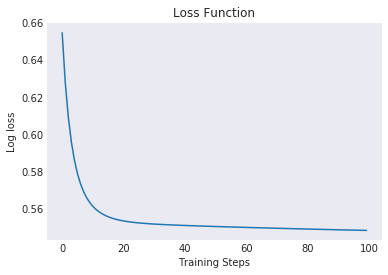

In [24]:
# training process

nSteps = 100
# append 0s for intercept
model = np.append([0], np.repeat(0, 2))
print(f"BASELINE:  Loss = {Loss(sample_df_toy_rdd,model)}")
print(f"BASELINE:  Model = {model}")
trace = []
print("showing the first 5 steps in print, the rest in chart")

for idx in range(nSteps):
    model = GDUpdate(sample_df_toy_rdd, model)
    loss = Loss(sample_df_toy_rdd, model) 
    if (idx < 5):
        # show only the 5 steps
        print("----------")
        print(f"STEP: {idx+1}")
        print(f"Loss: {loss}")
        print(f"Model: {[round(w,3) for w in model]}")
    trace = np.append(trace, [loss])

g = sns.lineplot(x=range(nSteps), y=trace)
g.set_title('Loss Function')
g.set_xlabel('Training Steps')
g.set_ylabel('Log loss')

print(f'Final model: Model = {model}')

# Getting prediction
pred = sample_df_toy_rdd.map(lambda x: (np.append([1.0], x[0]), x[1]))\
                        .map(lambda x: 1 * (1/(1 + np.exp(- np.dot(model, x[0]))) > 0.5))\
                        .collect()


* Just to verify our results with a standard implementation from SKlearn:

In [25]:
# compare coef and f1-score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
sample_df_toy_pandas = sample_df_toy.select('c01_ts', 'b09_t1', 'label').toPandas()
skl_model = LogisticRegression(fit_intercept=True)
skl_model.fit(sample_df_toy_pandas[['c01_ts', 'b09_t1']], sample_df_toy_pandas['label'])
print(f'SKLearn logistic model weights: {np.append(skl_model.intercept_, skl_model.coef_)}')
print(f'Self-implemented model weights: {model}')
skl_pred = skl_model.predict(sample_df_toy_pandas[['c01_ts', 'b09_t1']])
print(f'SKLearn logistic model f1-score: {round(f1_score(y_pred=skl_pred, y_true=sample_df_toy_pandas.label), 3)}')
print(f'Self-implemented model f1-score: {round(f1_score(y_pred = pred, y_true = sample_df_toy_pandas.label), 3)}')


SKLearn logistic model weights: [-1.03740904  0.5448784   0.05474129]
Self-implemented model weights: [-0.87190886  0.58637348 -0.15645926]
SKLearn logistic model f1-score: 0.333
Self-implemented model f1-score: 0.333


/opt/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0,0.5,'Sklearn')

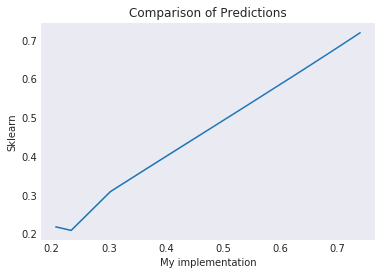

In [26]:
# compare predictions
pred_prob = sample_df_toy_rdd.map(lambda x: (np.append([1.0], x[0]), x[1]))\
                    .map(lambda x: (1/(1 + np.exp(- np.dot(model, x[0])))))\
                    .collect()
g = sns.lineplot(x=pred_prob, 
                 y=[x[1] for x in skl_model.predict_proba(sample_df_toy_pandas[['c01_ts', 'b09_t1']])])
g.set_title('Comparison of Predictions')
g.set_xlabel('My implementation')
g.set_ylabel('Sklearn')

* Observations:
    - the model coefficients are slightly off because we are only looking at numerical solutions for logistic regression, which also depends on initialization, learning rate, number of steps and a variety of parameters. 
    - despite of that, the probability predictions are quite similar between the two implementations, which shows that our algorithm at least get most of the things correct;
    - the f1 score is exactly the same is quite coincidental given that we only have 100 data points in this toy training set. 

# EDA & Discussion of Challenges

* categorical features 
* numerical features
* discussion of challenges

## Categorical Features

* There are 26 categorical features in the data set, but each will have varying number of categories that is hashed. 

In [12]:
categorical_features = [t[0] for t in sample_df.dtypes if t[1] == 'string']
categorical_features

['b01',
 'b02',
 'b03',
 'b04',
 'b05',
 'b06',
 'b07',
 'b08',
 'b09',
 'b10',
 'b11',
 'b12',
 'b13',
 'b14',
 'b15',
 'b16',
 'b17',
 'b18',
 'b19',
 'b20',
 'b21',
 'b22',
 'b23',
 'b24',
 'b25',
 'b26']

* The first things we want to explore with the categorical features is the number of unique categories in each one of them. 

In [13]:
features_summary = pd.DataFrame(columns=['name', '# unique', '# empty', 
                                         '# count = 1', '# count < 10', '# count < 100', 
                                         '# count < 1000'])
for c in categorical_features:
    # number of categories
    nc = len(sample_df_pd.loc[:, c].unique())
    # number of empty strings
    ne = sum(sample_df_pd.loc[:, c] == '')
    # number of categories with only 1 counts
    n1 = sum(sample_df_pd.loc[:, c].value_counts() == 1)
    # number of categories with less than 10 occurances
    n10 = sum(sample_df_pd.loc[:, c].value_counts() < 10)
    # number of categories with less than 100 occurances
    n100 = sum(sample_df_pd.loc[:, c].value_counts() < 100)
    # number of categories with less than 1000 occurances, which is about 1%
    n1000 = sum(sample_df_pd.loc[:, c].value_counts() < 1000)
    
    features_summary.loc[-1] = [c, nc, ne, n1, n10, n100, n1000]
    features_summary.index = features_summary.index + 1


In [14]:
features_summary

,name,# unique,# empty,# count = 1,# count < 10,# count < 100,# count < 1000
25,b01,536,0,255,432,505,527
24,b02,518,0,30,140,381,499
23,b03,46692,3408,41673,45968,46621,46689
22,b04,25550,3408,19263,24565,25453,25543
21,b05,143,0,55,104,127,137
20,b06,12,12025,2,4,5,5
19,b07,8042,0,1985,6003,7901,8040
18,b08,235,0,87,173,214,228
17,b09,3,0,0,0,1,1
16,b10,12032,0,5848,10592,11948,12030


* A few observations from the analysis above:
    - columns `b03`, `b04`, `b12`, `b16`, `b21`, `b24` all have 3408 empty strings; columns `b19`,  `b20`, `b25` and `b26` all have 43810 empty strings. And therefore, these columns might be related. 
    -  the distribution of categories are very skewed: for example, column `b04` has 25k unique categories, but 19K of them only have 1 occurances. Based on this observation, we could impute the categories with less than 1000 (which is 1% of the sample) count with some string, which will help reduce the number of unique categories.
    
After the imputation, the features summary goes as follows:

In [15]:
categorical_features_select = []
features_summary = pd.DataFrame(columns=['name', '# unique before', '# unique after', 
                                         'larger_than_1pc'])
for c in categorical_features:
    # number of categories
    nc_bf = len(sample_df_pd.loc[:, c].unique())
    
    if c in ['b03', 'b03', 'b12', 'b16', 'b21', 'b24']:
        sample_df_pd.loc[sample_df_pd.loc[:, c] == '', c] = 'empty_1'
    elif c in ['b19', 'b20', 'b25', 'b26']:
        sample_df_pd.loc[sample_df_pd.loc[:, c] == '', c] = 'empty_2'
    else:
        sample_df_pd.loc[sample_df_pd.loc[:, c] == '', c] = 'empty_0'
        
    less_than_1000 = list(sample_df_pd.loc[:, c].value_counts()[sample_df_pd.loc[:, c].value_counts() < 1000].index)
    sample_df_pd.loc[sample_df_pd.loc[:, c].isin(less_than_1000), c] = 'less_than_1pc'
    larger_than_1pc = [x for x in sample_df_pd.loc[:, c].unique() if x not in ['less_than_1pc']]          
    nc_af = len(sample_df_pd.loc[:, c].unique())
    
    features_summary.loc[-1] = [c, nc_bf, nc_af, larger_than_1pc]
    features_summary.index = features_summary.index + 1


In [16]:
features_summary

,name,# unique before,# unique after,larger_than_1pc
25,b01,536,10,"[5a9ed9b0, 05db9164, 8cf07265, 68fd1e64, 87552..."
24,b02,518,20,"[80e26c9b, 58e67aaf, 38a947a1, 09e68b86, 28713..."
23,b03,46692,4,"[empty_1, d032c263, 02cf9876]"
22,b04,25550,8,"[d16679b9, empty_0, c18be181, 85dd697c, f922ef..."
21,b05,143,7,"[4cf72387, 25c83c98, 43b19349, 30903e74, 38487..."
20,b06,12,8,"[empty_0, 7e0ccccf, fbad5c96, 6f6d9be8, fe6b92..."
19,b07,8042,3,"[1c86e0eb, dc7659bd]"
18,b08,235,8,"[0b153874, 5b392875, 1f89b562, 37e4aa92, 062b5..."
17,b09,3,3,"[a73ee510, 7cc72ec2]"
16,b10,12032,3,"[3b08e48b, efea433b]"


* For now, we select all the categorical variables for building the models. Based on the insights of the models we tested, we'd make further selections on the categorical features. 

In [17]:
categorical_features_select = categorical_features

In [18]:
sample_df_pd.loc[:, 'b17'].unique()

array(['1e88c74f', 'e5ba7672', 'd4bb7bd8', '776ce399', '2005abd1',
       '07c540c4', '27c07bd6', '3486227d', '8efede7f'], dtype=object)

## Numerical Features

* first thing we did is to print out the sumamry of the numerical features: the average, the standard deviation, the minimum and maximum.

In [19]:
numeric_features = [t[0] for t in sample_df.dtypes if t[1] == 'double']
sample_df.select(numeric_features).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
c01,100085,1.9143927661487736,7.963545316430234,0.0,1262.0
c02,100085,104.71580156866663,385.10183633182993,-2.0,14091.0
c03,100085,22.30975670679922,440.1846081342075,0.0,65535.0
c04,100085,5.694329819653294,8.480746485453276,0.0,681.0
c05,100085,17772.16770744867,67149.887509406,0.0,2145045.0
c06,100085,89.60239796173252,280.98876472572186,0.0,19247.0
c07,100085,15.872578308437827,62.784068480288276,0.0,5014.0
c08,100085,12.46940100914223,21.491367038089617,0.0,4449.0
c09,100085,101.00950192336514,219.34656667004475,0.0,9094.0


* Two observations from the summary above:
    - all of the numerical features are highly skewed
    - all of them are non-negative, except for the second one, which takes only 2 unique negative numbers

Based on the observations, we think log1p will be a suitable transformation for the numeric features.

In [20]:
sample_df_pd.loc[sample_df_pd.c02 < 0, 'c02'].unique()

array([-1., -2.])

* The second thing we looked at is the separation. The following plot shows the box plot of each variable by label, after transforming the y axis to log scale. What we see is that while the transformation brings the features to similar ranges, it is not quite clear any feature shows apparent separation between the two values of the label. 

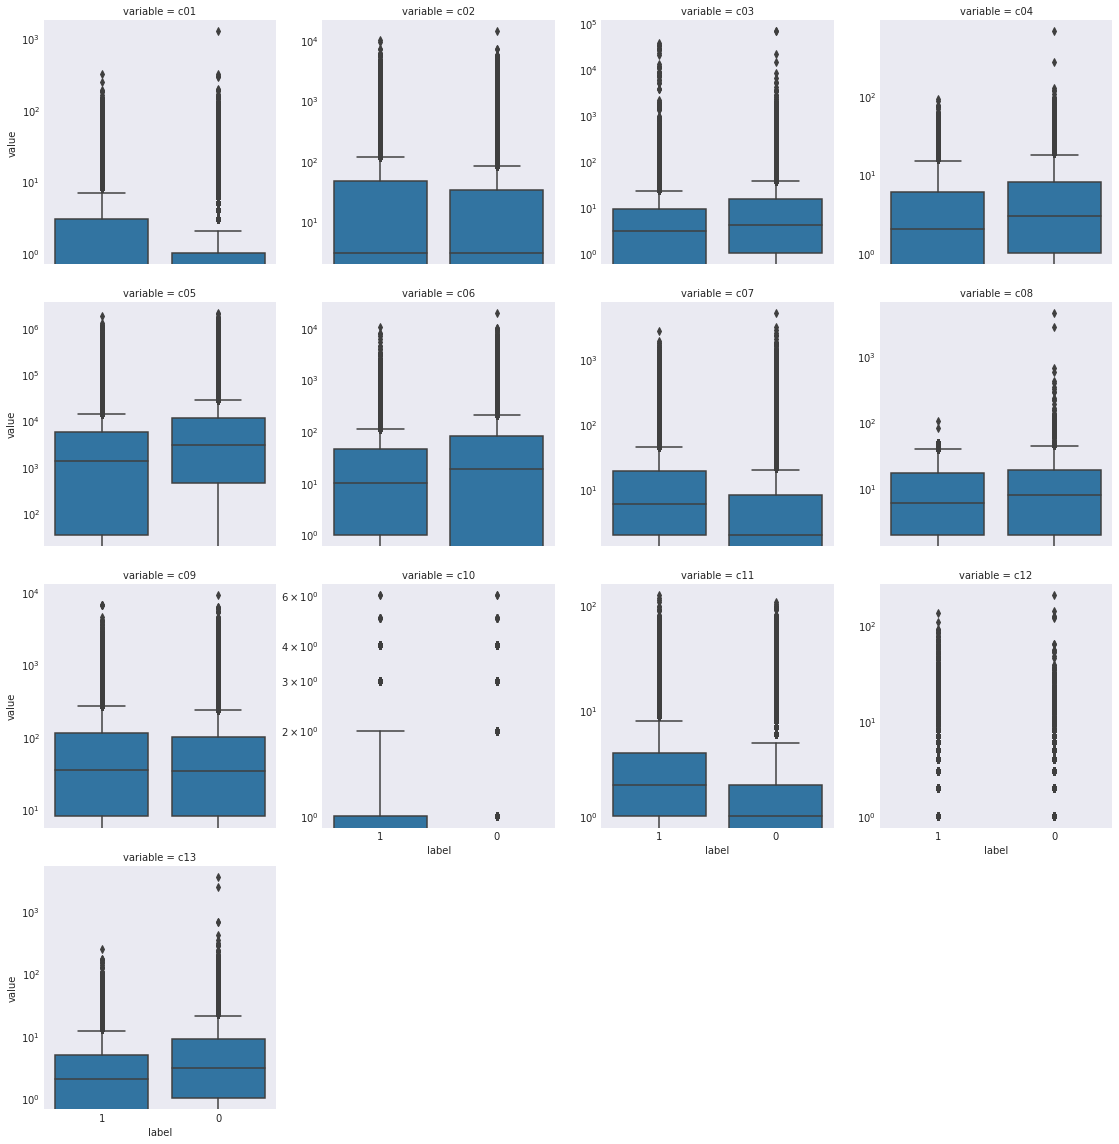

In [21]:
# plot separation
sample_df_pd_melt = pd.melt(sample_df_pd.loc[:, numeric_features + ['label']],
                            id_vars='label', value_vars=numeric_features)
g = sns.FacetGrid(sample_df_pd_melt, col="variable", col_wrap=4, height=4, sharex=True, sharey=False)
g.map(sns.boxplot, "label", "value", order = [1,0]).set(yscale = 'log')

* The third thing we explored for the numerical features is the correlation: both with the labels to get a sense of relationship, and amongst themselves on the look out for multi-colinearity. 

In [22]:
corr = sample_df_pd.loc[:, numeric_features + ['label']].corr()
corr

,c01,c02,c03,c04,c05,c06,c07,c08,c09,c10,c11,c12,c13,label
c01,1.000000,0.029119,0.037375,0.069616,-0.062561,-0.063534,0.447207,0.066030,0.062534,0.418429,0.277886,0.119862,0.003401,0.089009
c02,0.029119,1.000000,-0.007154,-0.078831,-0.013368,-0.017233,0.026975,-0.022519,-0.007059,0.039292,0.034220,-0.004761,-0.029722,0.044987
c03,0.037375,-0.007154,1.000000,0.046587,-0.002586,-0.002590,0.002417,0.044583,-0.001243,-0.004169,-0.006529,-0.001192,0.033827,0.008301
c04,0.069616,-0.078831,0.046587,1.000000,-0.089711,0.015545,0.042726,0.537345,0.200459,0.150895,0.064474,0.017904,0.651441,-0.058870
c05,-0.062561,-0.013368,-0.002586,-0.089711,1.000000,0.003658,-0.059119,-0.084217,-0.065704,-0.148382,-0.114402,-0.023763,-0.045432,-0.073363
c06,-0.063534,-0.017233,-0.002590,0.015545,0.003658,1.000000,-0.035144,0.018459,0.229015,-0.149683,-0.047332,-0.015350,0.049010,-0.066896
c07,0.447207,0.026975,0.002417,0.042726,-0.059119,-0.035144,1.000000,0.062784,0.244754,0.265312,0.716607,0.094481,0.002930,0.085368
c08,0.066030,-0.022519,0.044583,0.537345,-0.084217,0.018459,0.062784,1.000000,0.177030,0.118802,0.105069,0.023201,0.782643,-0.025412
c09,0.062534,-0.007059,-0.001243,0.200459,-0.065704,0.229015,0.244754,0.177030,1.000000,0.074868,0.404092,0.050513,0.197628,0.022968
c10,0.418429,0.039292,-0.004169,0.150895,-0.148382,-0.149683,0.265312,0.118802,0.074868,1.000000,0.388584,0.098616,0.019183,0.189637


Text(0.5,1,'Correlation between Numerical Columns and Label')

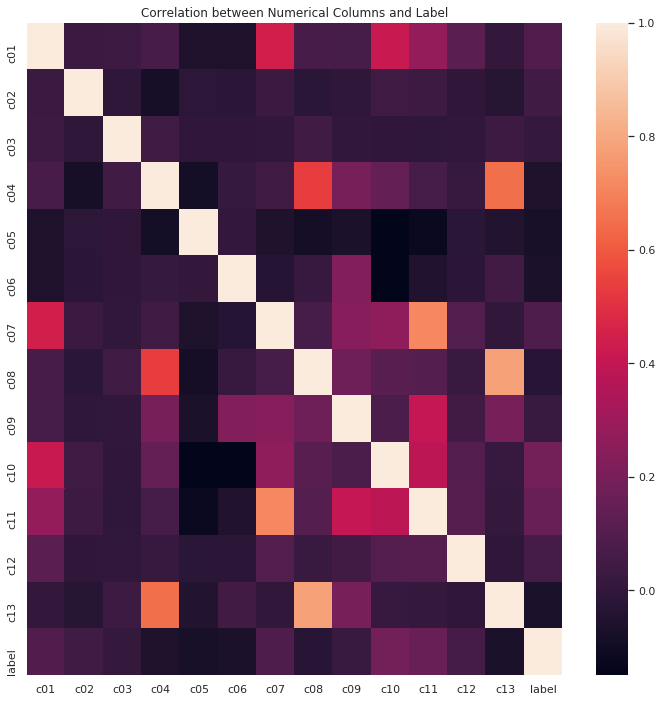

In [23]:
# plot correlation
sns.set(rc={'figure.figsize':(12, 12)})
g = sns.heatmap(corr)
g.set_title('Correlation between Numerical Columns and Label')

* And finally, we tried to use some scatter plot searching for obvious relationship, yet given the range of data we don't think we see anything too obvious. 

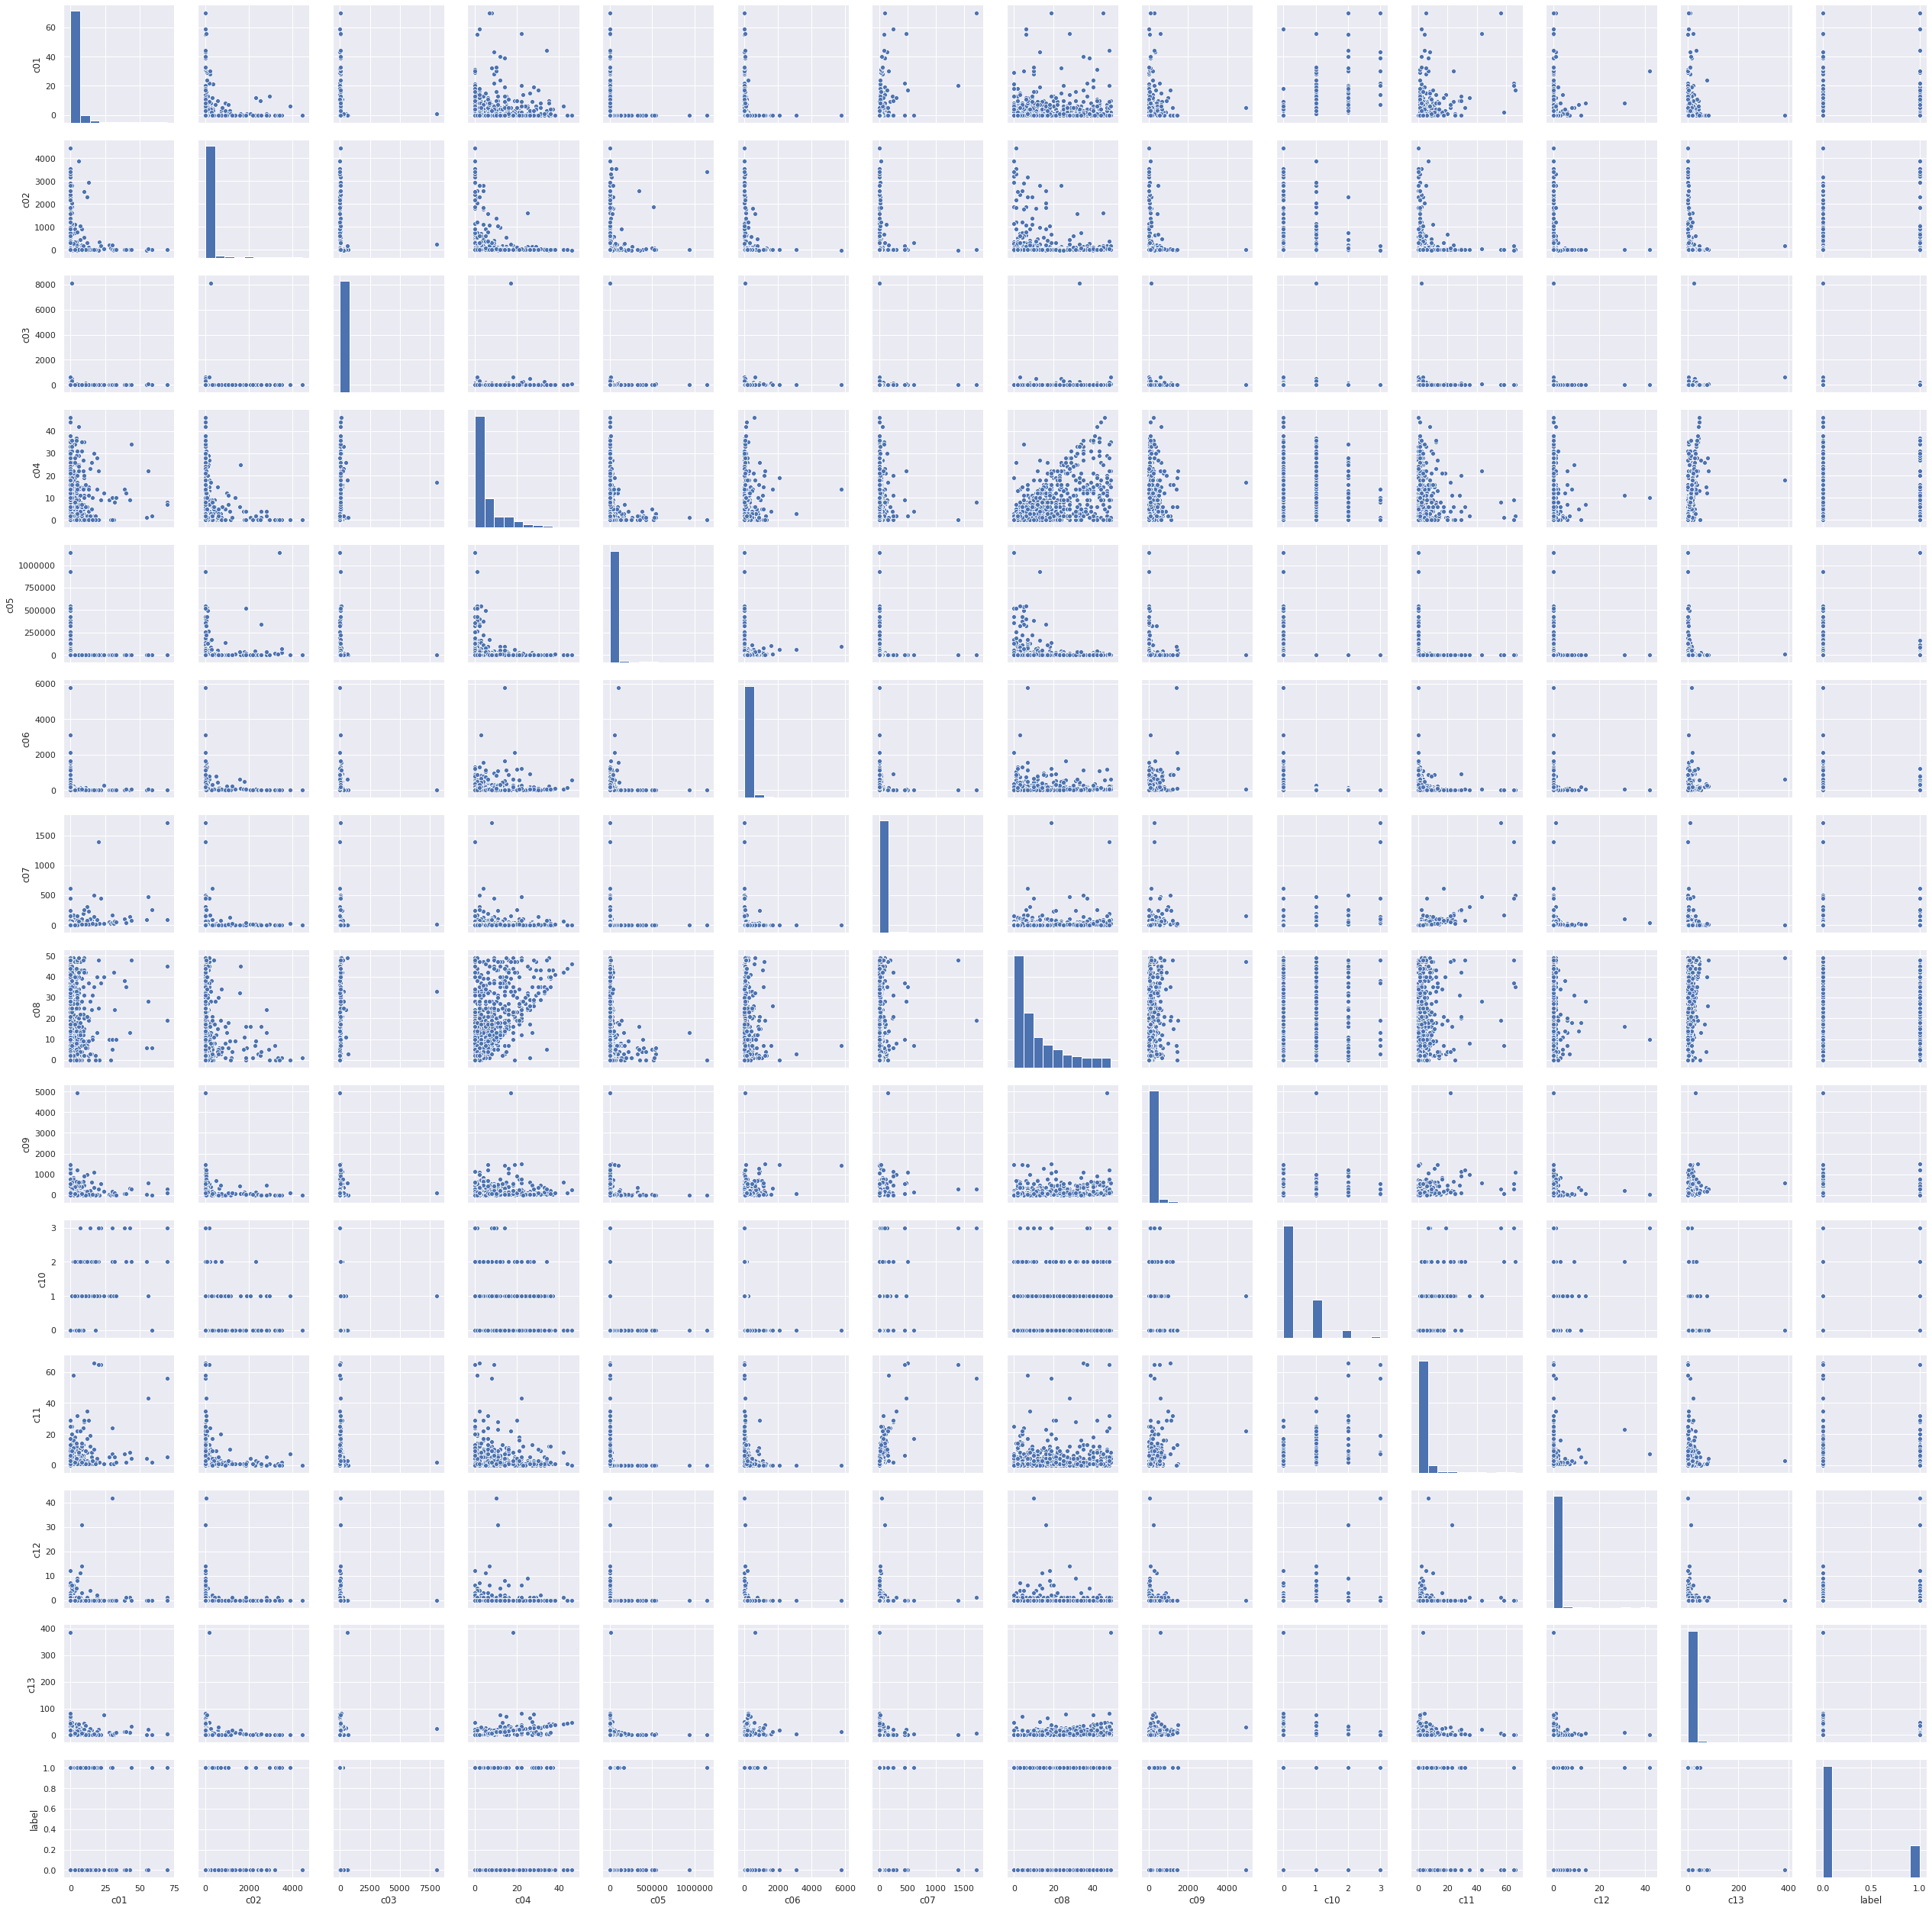

In [50]:
sns.pairplot(sample_df_pd.sample(n=1000, random_state=1).loc[:, numeric_features + ['label']])

## Discussion of Challenges

There are unique challenges to this problem:

* The sheer size of the data makes it unsuitable for the typical tools people use for modeling, such as Pandas and SKlearn, which is why we choose to do it with Spark MLlib.
* The complexity of the features space would normally require a lot of domain knowledge, yet here the data is presented anonymously. Therefore, the research presented in this notebook will be based on statistical observations and practices.
* While researching into the problem, our team also keeps in mind the needs of real-time production. And that's why we have built Spark pipelines for the data, and depending on the business needs, we could efficiently deploy the code for updates/retrain of the model.


# Build Toy Models for Sampled Data

We developed two separate pipelines based on how the categorical features are treated:

* Numericals + Categoricals

    This is the more typical pipeline people use, where the categoricals are one-hot encoded and numericals are scaled
    
* Breiman's method

    The categoricals are replaced with their respective average labels, and hence transformed into numericals. 

This section is organized in the following logic:
    
* Evaluation metrics
* Numerical + Categorical
    1. Build pipeline + Train/Test split
    3. Decision Tree
    4. Logistic Regression
    5. Gradient Boosted Tree
* Breiman's Method
    1. Logistic Regression
    2. Gradient Boosted Tree

## Evaluation Metrics

The are two major aspects of any classification algorithm:

* how accurate the prediction is 
* how good the probability distributions are 



Based on this, there are two metrics that we focus on in this study:

   * f1-score: it is the harmonic mean of precision and recall, which presents a balanced view of how good the prediction is
   
       - Even though the event we are predicting is not extremely imbalanced like credit card default, f1-score still tells us more than simply the accuracy ratio. 
   
       - For the f-1 score, we have built our custom function, since the one in Spark only seems to work for multi-class classfication.  
       
   * Log loss: this is the objective function in Logistic Regression, which is an good indicator of the distribution of the predicted probabilities. 
   
       - There is no standard implementation of log loss in Spark MLlib, therefore we built our own, which takes input as `model.transform()`.

We believe the combination of the f1 score and log loss already will give us a 360-degree view of how the model is performing.  The intricate trade-offs between the two are detailed in the later sessions. 


In the code we also reported the AUC, because it is easy to implement.

In [118]:
# custom functions

from pyspark.sql.types import FloatType
def log_loss_from_prediction(predictions):
    # predictions are what returns from model.transform
    # the data frame should have a column named probability, which is a tuple:
    # we need to extract the second item of the tuple and calculate log loss with it
    # an exmaple of use:
    # predictions = lrModel.transform(test)
    # x = log_loss_from_prediction(predictions)
    epsilon = 1e-16
    split1_udf = udf(lambda value: value[1].item(), FloatType())
    predictions = predictions.select('*', split1_udf('probability').\
                                     alias('prob'))
    loss = predictions.select("*", 
                           when(predictions.label == 1, 0. - log(predictions.prob + epsilon)).\
                           otherwise(0. - log(1. - predictions.prob + epsilon)).\
                           alias('log_loss')).\
                agg({'log_loss': 'avg'}).\
                take(1)
    return loss

def f1_score(predictions, matrix = False, name = ''):
    # predictions are what returns from model.transform
    # an exmaple of use:
    # predictions = lrModel.transform(test)
    # x = f1_score(predictions)
    from pyspark.sql.functions import count
    agg = predictions.groupBy('prediction', 'label').agg(count("*")).collect()
    TP = agg[0][2]
    FN = agg[1][2]
    FP = agg[2][2]
    TN = agg[3][2]
    accuracy = (TN + TP) / (TN + TP + FN + FP)
    
    if (TP + FP > 0) and (TP + FN > 0):
        precision = TP / (TP + FP)
        recall = TP / (TP + FN)
        F =  2 * (precision*recall) / (precision + recall)
    else:
        F = 0
        
    if (matrix):
        # plot it out
        matrix = np.array([[TP, FN], [FP, TN]])
        cm_df = pd.DataFrame(matrix,
                         index = ['Positive', 'Nagative'], 
                         columns = ['Positive', 'Nagative'])
        subtitle = 'Precision ' + str(round(precision, 2)) + ' Recall ' + str(round(recall, 2))
        plt.figure(figsize=(6,4))
        sns.heatmap(cm_df, annot=True, fmt="d")
        plt.title('Confusion Matrix - ' + name + "\n" + subtitle)
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.show()

    return F

def eval(model, train, test, name, matrix = False):
    # this function evaluates the model, and returns a data frame

    print('Model:', name)
    predictions_train = model.transform(train)
    evaluator = BinaryClassificationEvaluator()
    train_roc = round(evaluator.evaluate(predictions_train), 6)
#     print('Train Area Under ROC', train_roc)
    ll_train = round(log_loss_from_prediction(predictions_train)[0][0], 6)
#     print('Train Area Log loss', ll_train)
    F_train = round(f1_score(predictions_train, matrix, 'Train'), 6)
#     print('Train F1-score', F_train)
    
    
    predictions_test = model.transform(test)
    test_roc = round(evaluator.evaluate(predictions_test), 6)
#     print('Test Area Under ROC', test_roc)
    ll_test = round(log_loss_from_prediction(predictions_test)[0][0], 6)
#     print('Test Area Log loss', ll_test)
    F_test = round(f1_score(predictions_test, matrix, 'Test'), 6)
#     print('Test F1-score', F_test)
    

    eval = pd.DataFrame({'Name': [name, name], 
                         'Data': ['Train', 'Test'],
                         'ROC': [train_roc, test_roc],
                         'LogLoss': [ll_train, ll_test], 
                         'F1-Score': [F_train, F_test]})
    print(eval)
    return(eval)

## Categorical + Numerics
### Build pipeline + Train/Test Split

* Categorical Features

    - We're imputing the empty categorical features with its own column name with "empty", otherwise the empty strings will throw error since column names can't be empty

    - For categories that represent less than 1 percent of the sample, we are encoding them with `_less_than_1pc` before the one-hot encoding. This drastically reduces the final feature space, as shown in the EDA

In [25]:
from pyspark.sql.functions import col, when, log, udf, log1p
def impute_blank(x):
    if x in ['b03', 'b03', 'b12', 'b16', 'b21', 'b24']:
        impute = 'empty_1'
    elif x in ['b19', 'b20', 'b25', 'b26']:
        impute = 'empty_2'
    else:
        impute = 'empty_0'
        
    return when(col(x) != "", col(x)).otherwise(impute)

def impute_1pc(x, less_than_1pc):
    return when(col(x).isin(list(larger_than_1pc)[0]), col(x)).otherwise('less_than_1pc')

for c in categorical_features_select:
    # every categorical feature:
    # 1) replace empty string with 'empty'
    # 2) replace categories with less than 1pc with a string
    larger_than_1pc = features_summary.larger_than_1pc[features_summary.name == c]
    sample_df = sample_df.withColumn(c, impute_blank(c))\
                         .withColumn(c, impute_1pc(c, larger_than_1pc))

* Numerical Features

For numerical columns, we are using `log1p` transformation, and then putting them through a standard scaler where each observation is de-meaned and divided by standard deviation. 

In [26]:
def log_transformation(x):
    return when(col(x) < 0, col(x)).otherwise(log1p(col(x)))

for n in numeric_features:
    # log1p on all numerical features
    # same for train and test
    sample_df = sample_df.withColumn(n, log_transformation(n))


* Pipeline
    - The categorical features are first indexed, and then one-hot encoded
    - the numerical features, given that they are already in the log space, are taken as they are
    - the scaler is applied to the feature space, with `selected_features` as the final features for modeling. 
    - originally, we also had the chi-squared selector in the pipeline which filters the features by looking at their relationship with the label. Yet, the features coming out of the selector didn't go with models such as SVM or random forest. On the other hand, it also did not significantly improve the performance of models like logitic regression. As a result, we decided to leave it out. 
    
After the pipeline, we have 202 features in total, which is a reasonable number given that we have about 50 million observations in the dataset. 

In [27]:
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler, StandardScaler, ChiSqSelector

stages = []
for categoricalCol in categorical_features_select:
    stringIndexer = StringIndexer(inputCol = categoricalCol, 
                                  outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], 
                                     outputCols=[categoricalCol + "classVec"], 
                                     handleInvalid='keep', dropLast = True)
    stages += [stringIndexer, encoder]
    
assemblerInputs =  [c + "classVec" for c in categorical_features_select] +numeric_features  #
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]
scaler = StandardScaler(inputCol='features', outputCol='selected_features',
                        withStd=True, withMean=True)
stages += [scaler]
# selector = ChiSqSelector(numTopFeatures=50, featuresCol="scaled_features",
#                          outputCol="selected_features", labelCol="label")
# stages += [selector]
stages

[StringIndexer_463ebc632c7f3edd887e,
 OneHotEncoderEstimator_4113a3c57471fa011ea0,
 StringIndexer_453e9cf9b5b17bc17159,
 OneHotEncoderEstimator_42ae8546a42c226a415f,
 StringIndexer_489d8fb61b8143a52bb1,
 OneHotEncoderEstimator_471d8c2c2729e46bc2c3,
 StringIndexer_409d9777b3ff77c94c81,
 OneHotEncoderEstimator_46199bebcd09fa1f0425,
 StringIndexer_464eab093f163fafbe46,
 OneHotEncoderEstimator_4fea8c182f756a0baf40,
 StringIndexer_4ee38e39ca06679795fe,
 OneHotEncoderEstimator_4840a7d6e05791253301,
 StringIndexer_4565a55f1daec22b96c5,
 OneHotEncoderEstimator_45de8713870609f8ab8c,
 StringIndexer_4c6c910ebb6a0a8b1dca,
 OneHotEncoderEstimator_4653b3cfa4d7bcf19b98,
 StringIndexer_420a9a046ce2e82d5ce7,
 OneHotEncoderEstimator_4544b2b266732567ec31,
 StringIndexer_4728974023be5b63ae66,
 OneHotEncoderEstimator_4dd7ac16dba7dd4e018b,
 StringIndexer_481189f09816a244695b,
 OneHotEncoderEstimator_4d1983372326aec2aa3d,
 StringIndexer_4c87a1b7bd87e2c3c43f,
 OneHotEncoderEstimator_4dbdbd6f84d91b291c69,
 Str

In [28]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(sample_df)
sample_df_pipe = pipelineModel.transform(sample_df)
selectedCols = ['label', 'selected_features'] #+ cols
sample_df_pipe = sample_df_pipe.select(selectedCols)
sample_df_pipe.printSchema()

root
 |-- label: long (nullable = true)
 |-- selected_features: vector (nullable = true)



After the pipeline we have 202 features, which is equal to number of unique categories (189) plus the number of numeric features (13). 

We didn't drop the last category of each column because the 1 hot encoded features are also put through the standard scaler, which frees us from the concerns of multi-colinearity. 

In [29]:
# number of features after pipeline
len(sample_df_pipe.select('selected_features').take(1)[0][0])

202

In [30]:
# total number of unique categories 
features_summary['# unique after'].sum()

189

In [31]:
# sanity check
189 + 13

202

**Train/Test Split**

* Given the metrics, we are splitting the sampled set with 100k observations further into training and testing set. 

* The same procedure is done once again on the full training set, since the original test set didn't come with labels.

In [32]:
train, test = sample_df_pipe.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 70044
Test Dataset Count: 30041


### Decision Tree Classifier

* Decision tree classifier with cross validation
* Feature importance and trimming
* Decision tree classifier with cross validation and sliced features


#### Decision Tree Classifier with Cross Validation

For hyper-parameter tuning, the team sets the paramGrid to test various options in the cross validation of decision tree.
* maxBins: The default setting is 32 bins, but the study also tries 16 bins to add penalization. We stop at 32 bins to avoid over-fitting.
* maxDepth: The team tests 2, 4, 6, 8 depth and stops at 8 to avoid over-fitting.
* impurity: The team uses both gini and entropy to understand information gain


In [33]:
%%time
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

dt = DecisionTreeClassifier(featuresCol = 'selected_features', labelCol = 'label', 
                            maxDepth = 5, seed = 8888)
paramGrid = ParamGridBuilder()\
             .addGrid(dt.maxDepth, [2, 4, 6, 8])\
             .addGrid(dt.impurity, ['gini', 'entropy'])\
             .addGrid(dt.maxBins, [16, 32])\
             .build()
ev = BinaryClassificationEvaluator(metricName='areaUnderROC')
cv = CrossValidator(estimator=dt, 
                    estimatorParamMaps=paramGrid, 
                    evaluator=ev, 
                    numFolds=3, seed = 8888)

cvModel = cv.fit(train)
dtModel = cvModel.bestModel

CPU times: user 2.66 s, sys: 880 ms, total: 3.54 s
Wall time: 3min 30s


In [38]:
bestBins = cvModel.bestModel._java_obj.getMaxBins()
bestDepth = cvModel.bestModel._java_obj.getMaxDepth()
bestImpurity = cvModel.bestModel._java_obj.getImpurity()
print('The best decision tree model has', bestDepth, 'layers,', bestBins, 
      'bins and using', bestImpurity, 'as impurity measure.')

The best decision tree model has 6 layers, 32 bins and using entropy as impurity measure.


In [39]:
eval_dt_cv = eval(cvModel, train, test, 'DT+CV')

Model: DT+CV
    Name   Data       ROC   LogLoss  F1-Score
0  DT+CV  Train  0.512806  0.512041  0.282334
1  DT+CV   Test  0.518036  0.529752  0.262007


The scores between train and test vary a bit, indicating that we might be over-fitting. It is a well-known disadvantage for Decision Tree, yet we started with this algorithm because we can easily calculate the feature importance based on gini index and use that for further features selection. 

#### Feature Importance and Trimming

In [40]:
featureImportance = list(cvModel.bestModel.featureImportances)
featureImportancePD = pd.DataFrame({'feature': list(range(len(featureImportance))), 
                                    'importance': featureImportance})
featureImportancePD.sort_values(by = 'importance', ascending=False).head(12)

,feature,importance
199,199,0.366069
194,194,0.279176
189,189,0.089996
191,191,0.077002
197,197,0.044970
201,201,0.028960
193,193,0.027015
96,96,0.022601
110,110,0.014402
196,196,0.006306


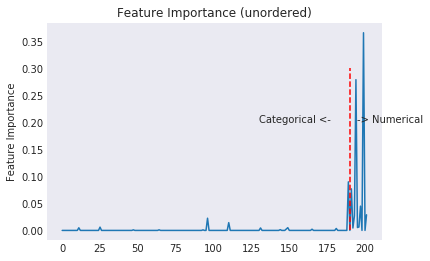

In [42]:
# plot out the feature importance
plt.plot(featureImportancePD.feature, featureImportancePD.importance)
plt.plot(np.repeat(202 - 13 + 1, 100), np.linspace(0, .3, 100),  'r', ls = '--')
plt.ylabel('Feature Importance')
plt.title('Feature Importance (unordered)')
plt.text(130, .2, 'Categorical <-')
plt.text(195, .2, '-> Numerical')
plt.show()

* There are 23 features (out of 202) that are shown to be "important". If we were to further trim down the features space, wonder what that will do to the performance. The intuition there is that the less features we have, the more "regular" the loss surface will be and the less likely we are to overfit. 

In [43]:
features_lt0 = list(featureImportancePD[featureImportancePD.importance > 0.0].feature)
len(features_lt0)

23

In [44]:
from pyspark.ml.feature import VectorSlicer
slicer = VectorSlicer(inputCol="selected_features", outputCol="sliced_features", indices=features_lt0)
train_sliced = slicer.transform(train)
test_sliced = slicer.transform(test)
train_sliced.show(5)

+-----+--------------------+--------------------+
|label|   selected_features|     sliced_features|
+-----+--------------------+--------------------+
|    0|[-1.0016849885468...|[-0.3580504012046...|
|    0|[-1.0016849885468...|[-0.3580504012046...|
|    0|[-1.0016849885468...|[-0.3580504012046...|
|    0|[-1.0016849885468...|[-0.3580504012046...|
|    0|[-1.0016849885468...|[-0.3580504012046...|
+-----+--------------------+--------------------+
only showing top 5 rows



#### Decision Tree Classifier with Cross Validation and Sliced Features

In [45]:
%%time
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(featuresCol = 'sliced_features', labelCol = 'label', 
                            maxDepth = 5, seed = 8888)
paramGrid = ParamGridBuilder()\
             .addGrid(dt.maxDepth, [2, 4, 6, 8, 10])\
             .addGrid(dt.impurity, ['gini', 'entropy'])\
             .addGrid(dt.maxBins, [16, 32])\
             .build()
ev = BinaryClassificationEvaluator(metricName='areaUnderROC')
cv = CrossValidator(estimator=dt, 
                    estimatorParamMaps=paramGrid, 
                    evaluator=ev, 
                    numFolds=3, seed = 8888)

cvModel = cv.fit(train_sliced)
dtModel = cvModel.bestModel

CPU times: user 1.9 s, sys: 1 s, total: 2.9 s
Wall time: 2min 57s


In [46]:
bestBins = cvModel.bestModel._java_obj.getMaxBins()
bestDepth = cvModel.bestModel._java_obj.getMaxDepth()
bestImpurity = cvModel.bestModel._java_obj.getImpurity()
print('The best decision tree model has', bestDepth, 'layers,', bestBins, 
      'bins and using', bestImpurity, 'as impurity measure.')

The best decision tree model has 4 layers, 32 bins and using entropy as impurity measure.


In [47]:
eval_dt_sliced_cv = eval(cvModel, train_sliced, test_sliced, name = 'DT+CV+S')

Model: DT+CV+S
      Name   Data       ROC   LogLoss  F1-Score
0  DT+CV+S  Train  0.515661  0.522705  0.303729
1  DT+CV+S   Test  0.517672  0.529677  0.294018


The Decision Tree model will be a baseline model for us. Given the winning score log loss is .47 and this model is showing .53, it shows us that we are at least on the right track. 

### Logistic Regression
* Logistic regression with default parameters
* Logistic regression with parameter tuning
* Logistic regression with parameter tuning and sliced features

#### Logistic Regression with Default Parameters

In [34]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'selected_features', labelCol = 'label', 
                        maxIter=10, regParam=0, elasticNetParam=0)
lrModel = lr.fit(train)
trainingSummary = lrModel.summary

In [35]:
# optimize the threshold
fMeasure = trainingSummary.fMeasureByThreshold
maxFMeasure = fMeasure.groupBy().max('F-Measure').select('max(F-Measure)').head()
bestThreshold = fMeasure.where(fMeasure['F-Measure'] == maxFMeasure['max(F-Measure)']) \
                        .select('threshold').head()['threshold']
lr.setThreshold(bestThreshold)

LogisticRegression_4f3db3d25cf9f74b7251

In [51]:
eval_lr = eval(lrModel, train, test, 'LR')

Model: LR
  Name   Data       ROC   LogLoss  F1-Score
0   LR  Train  0.738119  0.498950  0.338664
1   LR   Test  0.730594  0.504101  0.335685


Text(0.5,1,'Training Loss')

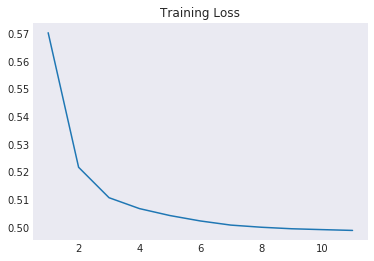

In [52]:
# plot out training loss
g = sns.lineplot(x=range(1, len(trainingSummary.objectiveHistory) + 1), 
                 y=trainingSummary.objectiveHistory)
g.set_title('Training Loss')

* There are 202 features in the logistic regression model (not including the intercept). Since the features are all normalized, the size of the coefficients should be a comparable scale. We see kind of a similar picture here as the feature importance chart shown from Decision Tree, yet categorical features seem to play a bigger role in this model.

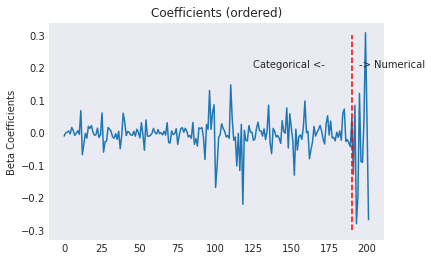

In [53]:
# plot out the coefs
beta = (lrModel.coefficients)
plt.plot(beta)
plt.plot(np.repeat(202-13+1, 100), np.linspace(-.3, 0.3, 100),  'r', ls = '--')
plt.ylabel('Beta Coefficients')
plt.title('Coefficients (ordered)')
plt.text(125, .2, 'Categorical <-')
plt.text(195, .2, '-> Numerical')
plt.show()

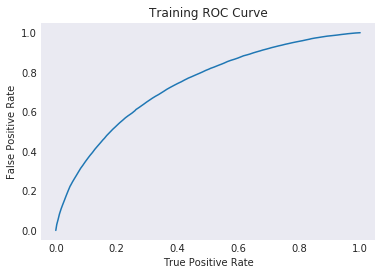

Training set areaUnderROC: 0.7380864336388292


In [54]:
# plot out the ROC curve
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('Training ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

#### Logistic Regression with Parameter Tuning

Here I'm maining tuning the `elasticNetParam` and `regParam`, which corresponds $\alpha$ and $\lambda$ in the following equation respectively $$L + \lambda[(1-\alpha)\sum\beta^2 + \alpha\sum|\beta|]$$

* when `elasticNetParam` is 0, it is purely l2 penalty; when it is 1, it is purely l1 penalty. Otherwise it is the weight between the 2. The choice here are 0, 0.5 and 1. 

* `regParam` is the sererity of the penalty, here we are incrementing it on log-scale. The sum of squared coefficients from the base model is .76, which is comparable to the loss. To add in regularization but not overwhelming the training, here the choices are 0.001, 0.002, 0.005 and 0.01.

In [37]:
%%time
lr = LogisticRegression(featuresCol = 'selected_features', labelCol = 'label', 
                        maxIter=10, regParam=0, elasticNetParam=0)

# Create 3-fold CrossValidator
evaluator = BinaryClassificationEvaluator()
paramGrid = ParamGridBuilder()\
    .addGrid(lr.elasticNetParam,[0.0, 0.5, 1.0])\
    .addGrid(lr.maxIter,[10, 50, 100])\
    .addGrid(lr.regParam,[0.001, 0.002, 0.005, 0.01]) \
    .build()
cv = CrossValidator(estimator = lr, estimatorParamMaps = paramGrid, 
                    evaluator = evaluator, numFolds=3, seed = 8888)

# Run cross validations
cvModel = cv.fit(train)

best_alpha = cvModel.bestModel._java_obj.getElasticNetParam()
best_lambda = cvModel.bestModel._java_obj.getRegParam()
print('Best elasticNetParam is', best_alpha)
print('Best regParam is', best_lambda)

Best elasticNetParam is 0.5
Best regParam is 0.001
CPU times: user 6.27 s, sys: 2.26 s, total: 8.53 s
Wall time: 21min 29s


Model: LR+CV


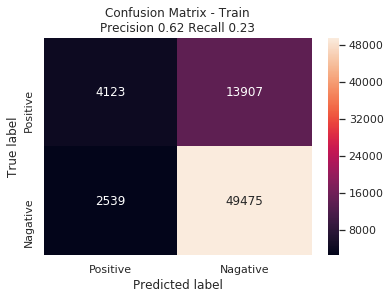

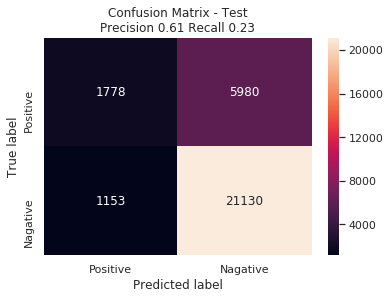

    Name   Data       ROC   LogLoss  F1-Score
0  LR+CV  Train  0.738823  0.498517  0.333954
1  LR+CV   Test  0.731641  0.503432  0.332678
CPU times: user 260 ms, sys: 70 ms, total: 330 ms
Wall time: 21.4 s


In [121]:
%%time
eval_lr_cv = eval(cvModel, train, test, 'LR+CV', matrix=True)

Here the regularization helped collapsed the gap between the train and test log loss. On the other hand, the loss is not a lot larger compared to before the training, since the best `regParm` is 0.001. 

From the confusion matrix, we see that we are doing well on the precision. That means for ads that we predict people will click on, 62% of the people will, wchih is pretty good. However, the recall is on the low side, meaning we are being conservative in our recommendations. This is a common problem people face when dealing with unbalanced dataset. Depending on the business strategy, people would decide on how aggressive they should be in terms of ad distribution. However, given the vague context we have in this project, we chose to focus more on the F1 score, which balances the two sides and serve as a safe choice. 

#### Sliced features on Linear Regression

In [57]:
%%time
lr = LogisticRegression(featuresCol = 'sliced_features', labelCol = 'label', 
                        maxIter=10, regParam=0, elasticNetParam=0)
paramGrid = ParamGridBuilder()\
    .addGrid(lr.elasticNetParam,[0.0, 0.5, 1.0])\
    .addGrid(lr.maxIter,[10, 50, 100])\
    .addGrid(lr.regParam,[0.001, 0.002, 0.005, 0.01]) \
    .build()

# Create 5-fold CrossValidator
cv = CrossValidator(estimator = lr, estimatorParamMaps = paramGrid, 
                    evaluator = evaluator, numFolds=3, seed = 8888)

# Run cross validations, use train_scliced here
cvModel = cv.fit(train_sliced)

best_alpha = cvModel.bestModel._java_obj.getElasticNetParam()
best_lambda = cvModel.bestModel._java_obj.getRegParam()
print('Best elasticNetParam is', best_alpha)
print('Best regParam is', best_lambda)

Best elasticNetParam is 0.5
Best regParam is 0.001
CPU times: user 4.65 s, sys: 2.65 s, total: 7.3 s
Wall time: 9min 44s


In [58]:
eval_lr_cv_sliced = eval(cvModel, train_sliced, test_sliced, 'LR+CV+S')

Model: LR+CV+S
      Name   Data       ROC   LogLoss  F1-Score
0  LR+CV+S  Train  0.713115  0.514463  0.276960
1  LR+CV+S   Test  0.707870  0.517995  0.277437


The sliced features don't seem to improving the performance here. We think it is because when we reduce the features space from 202 to 23, the information loss outweighs the supposed gain in parsimony. We expect this to be more dramatic when applied to the full dataset. 

### Gradient Boosted Trees
#### Gradient boosted trees with default parameters


In [124]:
from pyspark.ml.classification import GBTClassifier
gb = GBTClassifier(featuresCol = 'selected_features', labelCol = 'label', 
                   maxIter = 20, seed = 8888)
gbModel = gb.fit(train)
eval_gbt = eval(gbModel, train, test, 'GBT')

Model: GBT
  Name   Data       ROC   LogLoss  F1-Score
0  GBT  Train  0.743022  0.497953  0.340222
1  GBT   Test  0.720755  0.511109  0.315513


#### Gradient boosted trees with parameter tuning

The parameters we tuned here are:
* maxDepth: the gradient boosted tree usually performs quite well with depth larger than 10, yet the it would also tend to overfit. Therefore the choices stopped at 10
* maxBins: the default is 32, we also tried 16 but didn't go higher. 
* maxIter: the GBT in spark runs very slow and consumes a lot of memory. We weren't able to go further than 20, given the choices on the other parameters. 

In [125]:
%%time
# Create 3-fold CrossValidator
gb = GBTClassifier(featuresCol = 'selected_features', labelCol = 'label', 
                   maxIter = 20, seed = 8888)
paramGrid = ParamGridBuilder()\
    .addGrid(gb.maxDepth,[4, 6, 8, 10])\
    .addGrid(gb.maxBins,[16, 32])\
    .addGrid(gb.maxIter,[10]) \
    .build()
evaluator = BinaryClassificationEvaluator()
cv = CrossValidator(estimator = gb, estimatorParamMaps = paramGrid, 
                    evaluator = evaluator, numFolds=3)

# Run cross validations
cvModel = cv.fit(train)

best_maxDepth = cvModel.bestModel._java_obj.getMaxDepth()
best_maxBins = cvModel.bestModel._java_obj.getMaxBins()
best_maxIter = cvModel.bestModel._java_obj.getMaxIter()


CPU times: user 2.8 s, sys: 1.51 s, total: 4.31 s
Wall time: 13min 6s


Best maxDepth is 6
Best maxBins is 32
Best maxIter is 10
Model: GBT+CV


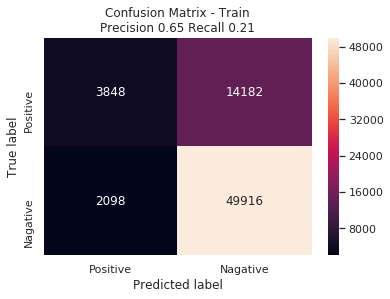

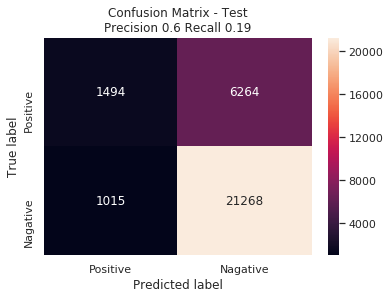

     Name   Data       ROC   LogLoss  F1-Score
0  GBT+CV  Train  0.743550  0.498562  0.320988
1  GBT+CV   Test  0.716025  0.514783  0.291030


In [126]:
print('Best maxDepth is', best_maxDepth)
print('Best maxBins is', best_maxBins)
print('Best maxIter is', best_maxIter)
eval_gbt_cv = eval(cvModel, train, test, 'GBT+CV', matrix = True)

### Summary for Categorical + Numerics

From the summary stats below, we recommend training both logistic regression and logistic regression for the full data set.

In [106]:
eval_all = eval_dt_cv.append([eval_dt_sliced_cv, eval_lr, eval_lr_cv, 
                              eval_lr_cv_sliced, eval_gbt, eval_gbt_cv])
eval_all

,Name,Data,ROC,LogLoss,F1-Score
0,DT+CV,Train,0.512806,0.512041,0.282334
1,DT+CV,Test,0.518036,0.529752,0.262007
0,DT+CV+S,Train,0.515661,0.522705,0.303729
1,DT+CV+S,Test,0.517672,0.529677,0.294018
0,LR,Train,0.738119,0.498950,0.338664
1,LR,Test,0.730594,0.504101,0.335685
0,LR+CV,Train,0.738823,0.498517,0.333954
1,LR+CV,Test,0.731641,0.503432,0.332678
0,LR+CV+S,Train,0.713115,0.514463,0.276960
1,LR+CV+S,Test,0.707870,0.517995,0.277437


## Breiman's Method

Here we are implementing Breiman's data transformation: replacing the categorical data with the average of labels. This allows us to convert categoricals to numerics, which reduces the features space. There are two versions of this method that we implemented:

1. Data transformation with imputed features:
    
    As discussed in the EDA, the categories are highly skewed. As a result, we propose to impute the categories that shows up less than 1 percent of the sample with string "less_than_1pc" before group by the categories and calculate the mean of each imputed category. 

2. Data transformation without imputing features: using the raw categories as they are. 



After implementing both versions, we see that the second version is grossly overfitting the data. Therefore we archived that version in the appendix, and highlight version 1 in this report in the following three sections:

* Data Transformation
* Logistic Regression
* Gradient Boosted Tree

### Data Transformation

In [63]:
# sample_df_bm = parquet_df.sample(fraction=100000/(34095179 + 11745438), seed=8888).cache()
for c in categorical_features_select:
    # every categorical feature:
    # 1) replace empty string with name_na
    # 2) replace categories with less than 1pc with a string
    larger_than_1pc = features_summary.larger_than_1pc[features_summary.name == c]
    sample_df_bm = sample_df_bm.withColumn(c, impute_blank(c))\
                               .withColumn(c, impute_1pc(c, larger_than_1pc))

In [64]:
train_bm, test_bm = sample_df_bm.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset Count: " + str(train_bm.count()))
print("Test Dataset Count: " + str(test_bm.count()))

Training Dataset Count: 70044
Test Dataset Count: 30041


In [65]:
!rm -rf full_data/temp/*

In [66]:
%%time
from pyspark.sql.functions import broadcast

for c in categorical_features:
    print(c)
    # get the categorical means
    means = train_bm.groupBy(c).agg({'label':'mean'})
    means = means.withColumnRenamed('avg(label)', c+'_bm')
    means = means.withColumnRenamed(c, 'r')
    
    # left join to train
    train_bm = train_bm.withColumnRenamed(c, 'l')
    train_bm.repartition('l')
    train_bm = train_bm.join(broadcast(means), train_bm.l == means.r, how = 'left').drop('l').drop('r')

    # left join to test
    test_bm = test_bm.withColumnRenamed(c, 'l')
    test_bm.repartition('l')
    test_bm = test_bm.join(broadcast(means), test_bm.l == means.r, how = 'left').drop('l').drop('r')
    
    # force it to repartition every 5 joins, otherwise the joining take FOREVER
    if c in ['b05', 'b10', 'b15', 'b20', 'b26']:
        print('repartition')
        train_bm.write.parquet("full_data/temp/trainbm.parquet" + c)
        test_bm.write.parquet("full_data/temp/testbm.parquet"+ c)
        train_bm = spark.read.parquet("full_data/temp/trainbm.parquet"+ c)
        test_bm = spark.read.parquet("full_data/temp/testbm.parquet"+ c)
        
test_bm = test_bm.na.fill(0)

b01
b02
b03
b04
b05
repartition
b06
b07
b08
b09
b10
repartition
b11
b12
b13
b14
b15
repartition
b16
b17
b18
b19
b20
repartition
b21
b22
b23
b24
b25
b26
repartition
CPU times: user 420 ms, sys: 340 ms, total: 760 ms
Wall time: 1min 25s


In [67]:
# now the features are all non-negative and numeric, log1p is a suitable transformation 
train_bm.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
c01,70044,1.923319627662612,8.456498868306182,0.0,1262.0
c02,70044,104.76753183713095,387.7734024368298,-2.0,14091.0
c03,70044,21.07773685112215,332.5048527295297,0.0,33086.0
c04,70044,5.691750899434641,8.601616225368913,0.0,681.0
c05,70044,17690.220390040547,67387.39750468069,0.0,2145045.0
c06,70044,89.34445491405403,276.8271078976037,0.0,10456.0
c07,70044,16.082505282393925,65.58877332646787,0.0,5014.0
c08,70044,12.45959682485295,24.091326774205186,0.0,4449.0
c09,70044,101.05192450459711,220.4359992919834,0.0,9094.0


In [68]:
test_bm.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
c01,30041,1.8935787756732465,6.674306248068302,0.0,320.0
c02,30041,104.59518657834293,378.8059701897496,-2.0,9580.0
c03,30041,25.182350787257416,622.7022559003697,0.0,65535.0
c04,30041,5.700342864751506,8.192138591520505,0.0,118.0
c05,30041,17963.23717585966,66593.5406237014,0.0,1680616.0
c06,30041,90.2038214440265,290.46445032769674,0.0,19247.0
c07,30041,15.383109750008321,55.69667464855535,0.0,2310.0
c08,30041,12.492260577211145,13.622089899931566,0.0,346.0
c09,30041,100.91058886188875,216.78878037004208,0.0,6697.0


In [69]:
for n in numeric_features + [b + '_bm' for b in categorical_features]:
    # log1p on all numerical features
    # same for train and test
    train_bm = train_bm.withColumn(n, log_transformation(n))
    test_bm = test_bm.withColumn(n, log_transformation(n))


In [70]:
# this pipeline will only contain the scaler and the assembler
stages = []
assemblerInputs =  [c + "_bm" for c in categorical_features_select] +numeric_features  #
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]
scaler = StandardScaler(inputCol='features', outputCol='selected_features',
                        withStd=True, withMean=True)
stages += [scaler]
stages

[VectorAssembler_4293b738cea5d75e37ea, StandardScaler_4115a8344a757c8536aa]

In [71]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(train_bm)
train = pipelineModel.transform(train_bm).select(['label', 'selected_features'])
train.printSchema()
test = pipelineModel.transform(test_bm).select(['label', 'selected_features'])
test.printSchema()

root
 |-- label: long (nullable = true)
 |-- selected_features: vector (nullable = true)

root
 |-- label: long (nullable = true)
 |-- selected_features: vector (nullable = true)



In [72]:
# make sure there is no Nulls after the transformation
# there is not supposed to be any for train, but check it anyways
from pyspark.sql.functions import isnan, when, count, col
train_bm.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in train_bm.columns]).collect()


[Row(c01=0, c02=0, c03=0, c04=0, c05=0, c06=0, c07=0, c08=0, c09=0, c10=0, c11=0, c12=0, c13=0, label=0, b01_bm=0, b02_bm=0, b03_bm=0, b04_bm=0, b05_bm=0, b06_bm=0, b07_bm=0, b08_bm=0, b09_bm=0, b10_bm=0, b11_bm=0, b12_bm=0, b13_bm=0, b14_bm=0, b15_bm=0, b16_bm=0, b17_bm=0, b18_bm=0, b19_bm=0, b20_bm=0, b21_bm=0, b22_bm=0, b23_bm=0, b24_bm=0, b25_bm=0, b26_bm=0)]

In [73]:
# if a category showed up in train but not test, it will be null in the test after the join
# since we already imputed the nulls with 0, here we shouldn't see any (and didn't)
test_bm.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in test_bm.columns]).collect()


[Row(c01=0, c02=0, c03=0, c04=0, c05=0, c06=0, c07=0, c08=0, c09=0, c10=0, c11=0, c12=0, c13=0, label=0, b01_bm=0, b02_bm=0, b03_bm=0, b04_bm=0, b05_bm=0, b06_bm=0, b07_bm=0, b08_bm=0, b09_bm=0, b10_bm=0, b11_bm=0, b12_bm=0, b13_bm=0, b14_bm=0, b15_bm=0, b16_bm=0, b17_bm=0, b18_bm=0, b19_bm=0, b20_bm=0, b21_bm=0, b22_bm=0, b23_bm=0, b24_bm=0, b25_bm=0, b26_bm=0)]

In [74]:
train.count()

70044

In [75]:
test.count()

30041

### Logistic Regression with Breiman's method

Text(0.5,1,'Training Loss')

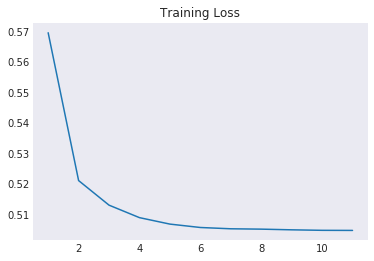

In [76]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'selected_features', labelCol = 'label', 
                        maxIter=10, regParam=0, elasticNetParam=0)
lrModel = lr.fit(train)
trainingSummary = lrModel.summary
g = sns.lineplot(x=range(1, len(trainingSummary.objectiveHistory) + 1), 
                 y=trainingSummary.objectiveHistory)
g.set_title('Training Loss')

In [77]:
fMeasure = trainingSummary.fMeasureByThreshold
maxFMeasure = fMeasure.groupBy().max('F-Measure').select('max(F-Measure)').head()
bestThreshold = fMeasure.where(fMeasure['F-Measure'] == maxFMeasure['max(F-Measure)']) \
                        .select('threshold').head()['threshold']
lr.setThreshold(bestThreshold)
predictions = lrModel.transform(test)
# predictions.show(10)

In [78]:
eval_lr_bm = eval(lrModel, train, test, 'LR+BM')

Model: LR+BM
    Name   Data       ROC   LogLoss  F1-Score
0  LR+BM  Train  0.728219  0.504692  0.312716
1  LR+BM   Test  0.726216  0.508085  0.314968


We got similar (slightly higher) loss rate than the logistic regression in the other pipeline, which shows Breiman's method is an efficient way to deal with categorical variables, especially if the number of unique categories are so big that one-hot encoding it is not feasible

### Gradient Boosted Trees with Breiman's Method

In [79]:
from pyspark.ml.classification import GBTClassifier
gb = GBTClassifier(featuresCol = 'selected_features', labelCol = 'label', 
                   maxIter = 20, seed = 8888)
gbModel = gb.fit(train)
eval_gbt_bm = eval(gbModel, train, test, 'GBT+BM')

Model: GBT+BM
     Name   Data       ROC   LogLoss  F1-Score
0  GBT+BM  Train  0.744219  0.496481  0.327607
1  GBT+BM   Test  0.727692  0.508713  0.315204


### Summary for Breiman's Method
GBT here showed similar results. Since the logistic regression will be more explainable, we chose to only run logistic regression when fitting the full data through Breiman's transformation in the next section. 

In [113]:
eval_all_BM = eval_lr_bm.append([eval_gbt_bm, eval_lr_bm_raw, eval_gbt_bm_raw])
eval_all_BM

,Name,Data,ROC,LogLoss,F1-Score
0,LR+BM,Train,0.728219,0.504692,0.312716
1,LR+BM,Test,0.726216,0.508085,0.314968
0,GBT+BM,Train,0.744219,0.496481,0.327607
1,GBT+BM,Test,0.727692,0.508713,0.315204
0,LR+BM Raw,Train,0.962717,0.208049,0.812294
1,LR+BM Raw,Test,0.617494,0.902251,0.263471
0,GBT+BM Raw,Train,0.966866,0.219323,0.810052
1,GBT+BM Raw,Test,0.531103,0.727883,0.260219


# Model with Full Data
* Categorical + Numerical
    - Logistic regression
    - Gradient boosted trees
* Breiman's Method
    - Logistic regression

This part is run in a jupyter notebook under environment GCP. We write to python files and submit it to the cluster for the calculation. 

## Categorical + Numerical

In [5]:
%%writefile full_data_lr.py

#!/usr/bin/env python

###################################
# IMPORTS
###################################
import re
import ast
import time
import numpy as np
import pandas as pd
from pyspark.sql import Row

###################################
# SETUP SPARK
###################################
# start Spark Session
from pyspark.sql import SparkSession
app_name = "final_project"
# master = "local[*]"
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .config('spark.executor.memory', '10g')\
        .getOrCreate()
# from pyspark import SparkContext
# SparkContext.setSystemProperty('spark.executor.memory', '15g')
sc = spark.sparkContext

###################################
# PIPE LINE
###################################
if False: 
    # write data to parquet, only needed to be run once
    df = sc.textFile('gs://261_bucket_zengm71/full_data/train.txt').\
            map(lambda l: l.split("\t")).\
            map(lambda p: Row(label=int(p[0]), 
                              c01 = int(p[1] + '0') / 10, c02 = int(p[2] + '0') / 10, c03 = int(p[3] + '0') / 10, c04 = int(p[4] + '0') / 10, c05 = int(p[5] + '0') / 10, c06 = int(p[6] + '0') / 10, 
                              c07 = int(p[7] + '0') / 10, c08 = int(p[8] + '0') / 10, c09 = int(p[9] + '0') / 10, c10 = int(p[10] + '0') / 10, c11 = int(p[11] + '0') / 10, c12 = int(p[12] + '0') / 10, 
                              c13 = int(p[13] + '0') / 10, 
                              b01 = p[14], b02 = p[15], b03 = p[16], b04 = p[17], b05 = p[18], b06 = p[19], b07 = p[20], b08 = p[21], b09 = p[22], b10 = p[23], b11 = p[24], b12 = p[25], b13 = p[26], 
                              b14 = p[27], b15 = p[28], b16 = p[29], b17 = p[30], b18 = p[31], b19 = p[32], b20 = p[33], b21 = p[34], b22 = p[35], b23 = p[36], b24 = p[37], b25 = p[38], b26 = p[39], ))

    # Infer the schema, and register the DataFrame as a table.
    schema_df = spark.createDataFrame(df)
    schema_df.createOrReplaceTempView("df")
    schema_df.write.parquet("gs://261_bucket_zengm71/full_data/train.parquet")

if False:
    # fit the full dataset through the pipeline and write to parquet
    # only need to be run once as well, unless any changes to the pipeline
    ###################################
    # Get the categories
    ###################################
    parquet_df = spark.read.parquet("gs://261_bucket_zengm71/full_data/train.parquet")

    # Parquet files can also be used to create a temporary view and then used in SQL statements.
    parquet_df.createOrReplaceTempView("parquet_df")
    parquet_df.printSchema()

    sample_df = parquet_df.sample(fraction=100000/(34095179 + 11745438), seed=8888).cache()
    print(sample_df.count())
    sample_df_pd = sample_df.toPandas()

    categorical_features = [t[0] for t in sample_df.dtypes if t[1] == 'string']
    features_summary = pd.DataFrame(columns=['name', '# unique', '# empty', 
                                             '# count = 1', '# count < 10', '# count < 100', 
                                             '# count < 1000'])
    for c in categorical_features:
        # number of categories
        nc = len(sample_df_pd.loc[:, c].unique())
        # number of empty strings
        ne = sum(sample_df_pd.loc[:, c] == '')
        # number of categories with only 1 counts
        n1 = sum(sample_df_pd.loc[:, c].value_counts() == 1)
        # number of categories with less than 10 occurances
        n10 = sum(sample_df_pd.loc[:, c].value_counts() < 10)
        # number of categories with less than 100 occurances
        n100 = sum(sample_df_pd.loc[:, c].value_counts() < 100)
        # number of categories with less than 1000 occurances, which is about 1%
        n1000 = sum(sample_df_pd.loc[:, c].value_counts() < 1000)

        features_summary.loc[-1] = [c, nc, ne, n1, n10, n100, n1000]
        features_summary.index = features_summary.index + 1

    categorical_features_select = []
    features_summary = pd.DataFrame(columns=['name', '# unique before', '# unique after', 
                                             'larger_than_1pc'])
    for c in categorical_features:
        # number of categories
        nc_bf = len(sample_df_pd.loc[:, c].unique())

        if c in ['b03', 'b03', 'b12', 'b16', 'b21', 'b24']:
            sample_df_pd.loc[sample_df_pd.loc[:, c] == '', c] = 'empty_1'
        elif c in ['b19', 'b20', 'b25', 'b26']:
            sample_df_pd.loc[sample_df_pd.loc[:, c] == '', c] = 'empty_2'
        else:
            sample_df_pd.loc[sample_df_pd.loc[:, c] == '', c] = 'empty_0'

        less_than_1000 = list(sample_df_pd.loc[:, c].value_counts()[sample_df_pd.loc[:, c].value_counts() < 1000].index)
        sample_df_pd.loc[sample_df_pd.loc[:, c].isin(less_than_1000), c] = 'less_than_1pc'
        larger_than_1pc = [x for x in sample_df_pd.loc[:, c].unique() if x not in ['less_than_1pc']]          
        nc_af = len(sample_df_pd.loc[:, c].unique())

        features_summary.loc[-1] = [c, nc_bf, nc_af, larger_than_1pc]
        features_summary.index = features_summary.index + 1
    categorical_features_select = categorical_features
    sample_df_pd.loc[:, 'b17'].unique()

    numeric_features = [t[0] for t in sample_df.dtypes if t[1] == 'double']

    ###################################
    # Preprocessing
    ###################################
    from pyspark.sql.functions import col, when, log, udf, log1p

    def impute_blank(x):
        if x in ['b03', 'b03', 'b12', 'b16', 'b21', 'b24']:
            impute = 'empty_1'
        elif x in ['b19', 'b20', 'b25', 'b26']:
            impute = 'empty_2'
        else:
            impute = 'empty_0'

        return when(col(x) != "", col(x)).otherwise(impute)


    def impute_1pc(x, larger_than_1pc):
        return when(col(x).isin(list(larger_than_1pc)[0]), col(x)).otherwise('less_than_1pc')

    def log_transformation(x):
        return when(col(x) < 0, col(x)).otherwise(log1p(col(x)))

    from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler, StandardScaler, ChiSqSelector
    stages = []
    for categoricalCol in categorical_features_select:
        stringIndexer = StringIndexer(inputCol = categoricalCol, 
                                      outputCol = categoricalCol + 'Index')
        encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], 
                                         outputCols=[categoricalCol + "classVec"])
        stages += [stringIndexer, encoder]

    assemblerInputs = [c + "classVec" for c in categorical_features_select] + numeric_features
    assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
    stages += [assembler]
    scaler = StandardScaler(inputCol='features', outputCol='selected_features',
                            withStd=True, withMean=True)
    stages += [scaler]
    # selector = ChiSqSelector(numTopFeatures=50, featuresCol="scaled_features",
    #                          outputCol="selected_features", labelCol="label")
    # stages += [selector]
    stages

    for c in categorical_features_select:
        larger_than_1pc = features_summary.larger_than_1pc[features_summary.name == c]
        parquet_df = parquet_df.withColumn(c, impute_blank(c))\
                               .withColumn(c, impute_1pc(c, larger_than_1pc))

    for n in numeric_features:
        parquet_df = parquet_df.withColumn(n, log_transformation(n))

    print('fitting the pipeline')
    from pyspark.ml import Pipeline
    pipeline = Pipeline(stages = stages)    
    pipelineModelFull = pipeline.fit(parquet_df)
    parquet_df_pipe = pipelineModelFull.transform(parquet_df)
    selectedCols = ['label', 'selected_features'] #+ cols
    parquet_df_pipe = parquet_df_pipe.select(selectedCols)
    parquet_df_pipe.printSchema()
    print(len(parquet_df_pipe.select('selected_features').take(1)[0][0]))
    print('writing to train.pipe.parquet')
    parquet_df_pipe.write.parquet("gs://261_bucket_zengm71/full_data/train.pipe.parquet")

###################################
# TRAIN/TEST Split
###################################
from pyspark.sql.functions import col, when, log, udf, log1p
from pyspark.sql.types import FloatType
def log_loss_from_prediction(predictions):
    # predictions are what returns from model.transform
    # the data frame should have a column named probability, which is a tuple:
    # we need to extract the second item of the tuple and calculate log loss with it
    epsilon = 1e-16
    split1_udf = udf(lambda value: value[1].item(), FloatType())
    predictions = predictions.select('*', split1_udf('probability').\
                                     alias('prob'))
    loss = predictions.select("*", 
                           when(predictions.label == 1, 0. - log(predictions.prob + epsilon)).\
                           otherwise(0. - log(1. - predictions.prob + epsilon)).\
                           alias('log_loss')).\
                agg({'log_loss': 'avg'}).\
                take(1)
    return loss

def f1_score(predictions):
    # predictions are what returns from model.transform
    # an exmaple of use:
    # predictions = lrModel.transform(test)
    # x = f1_score(predictions)
    TN = predictions.filter('prediction = 0 AND label = prediction').count()
    TP = predictions.filter('prediction = 1 AND label = prediction').count()
    FN = predictions.filter('prediction = 0 AND label <> prediction').count()
    FP = predictions.filter('prediction = 1 AND label <> prediction').count()
    accuracy = (TN + TP) / (TN + TP + FN + FP)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    F =  2 * (precision*recall) / (precision + recall)
    return F

parquet_df_pipe = spark.read.parquet("gs://261_bucket_zengm71/full_data/train.pipe.parquet")
print(len(parquet_df_pipe.select('selected_features').take(1)[0][0]))
train, test = parquet_df_pipe.randomSplit([0.7, 0.3], seed = 2018)
print("====== Training Dataset Count: " + str(train.count()))
print("====== Test Dataset Count: " + str(test.count()))

###################################
# LOGISTIC REGRESSION
###################################
print("====== Logistic Regression ========================================")
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

lr = LogisticRegression(featuresCol = 'selected_features', labelCol = 'label', 
                        maxIter=100, regParam=0.001, elasticNetParam=0.5)
lrModel = lr.fit(train)
trainingSummary = lrModel.summary

# Evaluate on Train
predictions = lrModel.transform(train)
evaluator = BinaryClassificationEvaluator()
f1 = f1_score(predictions)
print('====== Train Area Under ROC', evaluator.evaluate(predictions))
print('====== Train Log Loss: ', log_loss_from_prediction(predictions))
print('====== Train F1 Score: ', f1)

# Make Predictions
predictions = lrModel.transform(test)
evaluator = BinaryClassificationEvaluator()
f1 = f1_score(predictions)
print('====== Test Area Under ROC', evaluator.evaluate(predictions))
print('====== Test Log Loss: ', log_loss_from_prediction(predictions))
print('====== Test F1 Score: ', f1)


# ###################################
# # GBT
# ###################################
# print("====== Gradient Boosted Tress ========================================")
# from pyspark.ml.classification import GBTClassifier
# gb = GBTClassifier(featuresCol = 'selected_features', labelCol = 'label', 
#                    maxIter = 100, seed = 8888)
# gbModel = gb.fit(train)

# # Evaluate on Train
# predictions = gbModel.transform(train)
# evaluator = BinaryClassificationEvaluator()
# f1 = f1_score(predictions)
# print('====== Train Area Under ROC', evaluator.evaluate(predictions))
# print('====== Train Log Loss: ', log_loss_from_prediction(predictions))
# print('====== Train F1 Score: ', f1)

# # Make Predictions
# predictions = gbModel.transform(test)
# f1 = f1_score(predictions)
# evaluator = BinaryClassificationEvaluator()
# print('====== Test Area Under ROC', evaluator.evaluate(predictions))
# print('====== Test Log Loss: ', log_loss_from_prediction(predictions))
# print('====== Test F1 Score: ', f1)

spark.stop()

Overwriting full_data_lr.py


In [6]:
import time
start = time.time()
!python3 submit_job_to_cluster.py \
    --project_id=w261-256321 \
    --zone=us-west2-b \
    --cluster_name=final-project \
    --gcs_bucket=261_bucket_zengm71 \
    --key_file=$HOME/w261.json \
    --worker_nodes=15 \
    --create_new_cluster \
    --pyspark_file=full_data_lr.py
print(f'... completed job in {time.time() - start} seconds.')

Creating cluster...
Waiting for cluster creation...
Cluster created.
Uploading pyspark file to GCS
final-project - RUNNING
Submitted job ID f621583e-1c5a-4b0a-b417-670270e0315f
Waiting for job to finish...
Job finished.
b'====== Training Dataset Count: 32089468'
b'====== Test Dataset Count: 13751149'
b'====== Logistic Regression ========================================'
b'====== Train Area Under ROC 0.7355051192582652'
b'====== Train Log Loss:  [Row(avg(log_loss)=0.4994656972474252)]'
b'====== Train F1 Score:  0.32399346059737827'
b'====== Test Area Under ROC 0.7353038324506003'
b'====== Test Log Loss:  [Row(avg(log_loss)=0.49963011166872723)]'
b'====== Test F1 Score:  0.32409527565021723'
Tearing down cluster
... completed job in 2049.138465166092 seconds.


In [44]:
%%writefile full_data_gbt.py

#!/usr/bin/env python

###################################
# IMPORTS
###################################
import re
import ast
import time
import numpy as np
import pandas as pd
from pyspark.sql import Row

###################################
# SETUP SPARK
###################################
# start Spark Session
from pyspark.sql import SparkSession
app_name = "final_project"
# master = "local[*]"
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .config('spark.executor.memory', '10g')\
        .getOrCreate()
# from pyspark import SparkContext
# SparkContext.setSystemProperty('spark.executor.memory', '15g')
sc = spark.sparkContext

###################################
# PIPE LINE
###################################
if False: 
    # write data to parquet, only needed to be run once
    df = sc.textFile('gs://261_bucket_zengm71/full_data/train.txt').\
            map(lambda l: l.split("\t")).\
            map(lambda p: Row(label=int(p[0]), 
                              c01 = int(p[1] + '0') / 10, c02 = int(p[2] + '0') / 10, c03 = int(p[3] + '0') / 10, c04 = int(p[4] + '0') / 10, c05 = int(p[5] + '0') / 10, c06 = int(p[6] + '0') / 10, 
                              c07 = int(p[7] + '0') / 10, c08 = int(p[8] + '0') / 10, c09 = int(p[9] + '0') / 10, c10 = int(p[10] + '0') / 10, c11 = int(p[11] + '0') / 10, c12 = int(p[12] + '0') / 10, 
                              c13 = int(p[13] + '0') / 10, 
                              b01 = p[14], b02 = p[15], b03 = p[16], b04 = p[17], b05 = p[18], b06 = p[19], b07 = p[20], b08 = p[21], b09 = p[22], b10 = p[23], b11 = p[24], b12 = p[25], b13 = p[26], 
                              b14 = p[27], b15 = p[28], b16 = p[29], b17 = p[30], b18 = p[31], b19 = p[32], b20 = p[33], b21 = p[34], b22 = p[35], b23 = p[36], b24 = p[37], b25 = p[38], b26 = p[39], ))

    # Infer the schema, and register the DataFrame as a table.
    schema_df = spark.createDataFrame(df)
    schema_df.createOrReplaceTempView("df")
    schema_df.write.parquet("gs://261_bucket_zengm71/full_data/train.parquet")

if False:
    # fit the full dataset through the pipeline and write to parquet
    # only need to be run once as well, unless any changes to the pipeline
    ###################################
    # Get the categories
    ###################################
    parquet_df = spark.read.parquet("gs://261_bucket_zengm71/full_data/train.parquet")

    # Parquet files can also be used to create a temporary view and then used in SQL statements.
    parquet_df.createOrReplaceTempView("parquet_df")
    parquet_df.printSchema()

    sample_df = parquet_df.sample(fraction=100000/(34095179 + 11745438), seed=8888).cache()
    print(sample_df.count())
    sample_df_pd = sample_df.toPandas()

    categorical_features = [t[0] for t in sample_df.dtypes if t[1] == 'string']
    features_summary = pd.DataFrame(columns=['name', '# unique', '# empty', 
                                             '# count = 1', '# count < 10', '# count < 100', 
                                             '# count < 1000'])
    for c in categorical_features:
        # number of categories
        nc = len(sample_df_pd.loc[:, c].unique())
        # number of empty strings
        ne = sum(sample_df_pd.loc[:, c] == '')
        # number of categories with only 1 counts
        n1 = sum(sample_df_pd.loc[:, c].value_counts() == 1)
        # number of categories with less than 10 occurances
        n10 = sum(sample_df_pd.loc[:, c].value_counts() < 10)
        # number of categories with less than 100 occurances
        n100 = sum(sample_df_pd.loc[:, c].value_counts() < 100)
        # number of categories with less than 1000 occurances, which is about 1%
        n1000 = sum(sample_df_pd.loc[:, c].value_counts() < 1000)

        features_summary.loc[-1] = [c, nc, ne, n1, n10, n100, n1000]
        features_summary.index = features_summary.index + 1

    categorical_features_select = []
    features_summary = pd.DataFrame(columns=['name', '# unique before', '# unique after', 
                                             'larger_than_1pc'])
    for c in categorical_features:
        # number of categories
        nc_bf = len(sample_df_pd.loc[:, c].unique())

        if c in ['b03', 'b03', 'b12', 'b16', 'b21', 'b24']:
            sample_df_pd.loc[sample_df_pd.loc[:, c] == '', c] = 'empty_1'
        elif c in ['b19', 'b20', 'b25', 'b26']:
            sample_df_pd.loc[sample_df_pd.loc[:, c] == '', c] = 'empty_2'
        else:
            sample_df_pd.loc[sample_df_pd.loc[:, c] == '', c] = 'empty_0'

        less_than_1000 = list(sample_df_pd.loc[:, c].value_counts()[sample_df_pd.loc[:, c].value_counts() < 1000].index)
        sample_df_pd.loc[sample_df_pd.loc[:, c].isin(less_than_1000), c] = 'less_than_1pc'
        larger_than_1pc = [x for x in sample_df_pd.loc[:, c].unique() if x not in ['less_than_1pc']]          
        nc_af = len(sample_df_pd.loc[:, c].unique())

        features_summary.loc[-1] = [c, nc_bf, nc_af, larger_than_1pc]
        features_summary.index = features_summary.index + 1
    categorical_features_select = categorical_features
    sample_df_pd.loc[:, 'b17'].unique()

    numeric_features = [t[0] for t in sample_df.dtypes if t[1] == 'double']

    ###################################
    # Preprocessing
    ###################################
    from pyspark.sql.functions import col, when, log, udf, log1p

    def impute_blank(x):
        if x in ['b03', 'b03', 'b12', 'b16', 'b21', 'b24']:
            impute = 'empty_1'
        elif x in ['b19', 'b20', 'b25', 'b26']:
            impute = 'empty_2'
        else:
            impute = 'empty_0'

        return when(col(x) != "", col(x)).otherwise(impute)


    def impute_1pc(x, larger_than_1pc):
        return when(col(x).isin(list(larger_than_1pc)[0]), col(x)).otherwise('less_than_1pc')

    def log_transformation(x):
        return when(col(x) < 0, col(x)).otherwise(log1p(col(x)))

    from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler, StandardScaler, ChiSqSelector
    stages = []
    for categoricalCol in categorical_features_select:
        stringIndexer = StringIndexer(inputCol = categoricalCol, 
                                      outputCol = categoricalCol + 'Index')
        encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], 
                                         outputCols=[categoricalCol + "classVec"])
        stages += [stringIndexer, encoder]

    assemblerInputs = [c + "classVec" for c in categorical_features_select] + numeric_features
    assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
    stages += [assembler]
    scaler = StandardScaler(inputCol='features', outputCol='selected_features',
                            withStd=True, withMean=True)
    stages += [scaler]
    # selector = ChiSqSelector(numTopFeatures=50, featuresCol="scaled_features",
    #                          outputCol="selected_features", labelCol="label")
    # stages += [selector]
    stages

    for c in categorical_features_select:
        larger_than_1pc = features_summary.larger_than_1pc[features_summary.name == c]
        parquet_df = parquet_df.withColumn(c, impute_blank(c))\
                               .withColumn(c, impute_1pc(c, larger_than_1pc))

    for n in numeric_features:
        parquet_df = parquet_df.withColumn(n, log_transformation(n))

    print('fitting the pipeline')
    from pyspark.ml import Pipeline
    pipeline = Pipeline(stages = stages)    
    pipelineModelFull = pipeline.fit(parquet_df)
    parquet_df_pipe = pipelineModelFull.transform(parquet_df)
    selectedCols = ['label', 'selected_features'] #+ cols
    parquet_df_pipe = parquet_df_pipe.select(selectedCols)
    parquet_df_pipe.printSchema()
    print(len(parquet_df_pipe.select('selected_features').take(1)[0][0]))
    print('writing to train.pipe.parquet')
    parquet_df_pipe.write.parquet("gs://261_bucket_zengm71/full_data/train.pipe.parquet")

###################################
# TRAIN/TEST Split
###################################
from pyspark.sql.functions import col, when, log, udf, log1p
from pyspark.sql.types import FloatType

def log_loss_from_prediction(predictions):
    # predictions are what returns from model.transform
    # the data frame should have a column named probability, which is a tuple:
    # we need to extract the second item of the tuple and calculate log loss with it
    epsilon = 1e-16
    split1_udf = udf(lambda value: value[1].item(), FloatType())
    predictions = predictions.select('*', split1_udf('probability').\
                                     alias('prob'))
    loss = predictions.select("*", 
                           when(predictions.label == 1, 0. - log(predictions.prob + epsilon)).\
                           otherwise(0. - log(1. - predictions.prob + epsilon)).\
                           alias('log_loss')).\
                agg({'log_loss': 'avg'}).\
                take(1)
    return loss

def f1_score(predictions):
    # predictions are what returns from model.transform
    # an exmaple of use:
    # predictions = lrModel.transform(test)
    # x = f1_score(predictions)
    TN = predictions.filter('prediction = 0 AND label = prediction').count()
    TP = predictions.filter('prediction = 1 AND label = prediction').count()
    FN = predictions.filter('prediction = 0 AND label <> prediction').count()
    FP = predictions.filter('prediction = 1 AND label <> prediction').count()
    accuracy = (TN + TP) / (TN + TP + FN + FP)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    F =  2 * (precision*recall) / (precision + recall)
    return F

parquet_df_pipe = spark.read.parquet("gs://261_bucket_zengm71/full_data/train.pipe.parquet")
print(len(parquet_df_pipe.select('selected_features').take(1)[0][0]))

train, test = parquet_df_pipe.randomSplit([0.7, 0.3], seed = 2018)
print("====== Training Dataset Count: " + str(train.count()))
print("====== Test Dataset Count: " + str(test.count()))

###################################
# LOGISTIC REGRESSION
###################################
# print("====== Logistic Regression ========================================")
# from pyspark.ml.classification import LogisticRegression
# from pyspark.ml.evaluation import BinaryClassificationEvaluator

# lr = LogisticRegression(featuresCol = 'selected_features', labelCol = 'label', 
#                         maxIter=100, regParam=0.001, elasticNetParam=0.5)
# lrModel = lr.fit(train)
# trainingSummary = lrModel.summary

# # Evaluate on Train
# predictions = lrModel.transform(train)
# evaluator = BinaryClassificationEvaluator()
# f1 = f1_score(predictions)
# print('====== Train Area Under ROC', evaluator.evaluate(predictions))
# print('====== Train Log Loss: ', log_loss_from_prediction(predictions))
# print('====== Train F1 Score: ', f1)

# # Make Predictions
# predictions = lrModel.transform(test)
# evaluator = BinaryClassificationEvaluator()
# f1 = f1_score(predictions)
# print('====== Test Area Under ROC', evaluator.evaluate(predictions))
# print('====== Test Log Loss: ', log_loss_from_prediction(predictions))
# print('====== Test F1 Score: ', f1)


# ###################################
# # GBT
# ###################################
print("====== Gradient Boosted Tress ========================================")
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

gb = GBTClassifier(featuresCol = 'selected_features', labelCol = 'label', 
                   maxIter = 50, seed = 8888)
gbModel = gb.fit(train)

# Evaluate on Train
predictions = gbModel.transform(train)
evaluator = BinaryClassificationEvaluator()
f1 = f1_score(predictions)
print('====== Train Area Under ROC', evaluator.evaluate(predictions))
print('====== Train Log Loss: ', log_loss_from_prediction(predictions))
print('====== Train F1 Score: ', f1)

# Make Predictions
predictions = gbModel.transform(test)
f1 = f1_score(predictions)
evaluator = BinaryClassificationEvaluator()
print('====== Test Area Under ROC', evaluator.evaluate(predictions))
print('====== Test Log Loss: ', log_loss_from_prediction(predictions))
print('====== Test F1 Score: ', f1)

spark.stop()

Overwriting full_data_gbt.py


In [45]:
# GBT with 50 iterations
import time
start = time.time()
!python3 submit_job_to_cluster.py \
    --project_id=w261-256321 \
    --zone=us-west2-b \
    --cluster_name=final-project \
    --gcs_bucket=261_bucket_zengm71 \
    --key_file=$HOME/w261.json \
    --worker_nodes=23 \
    --create_new_cluster \
    --pyspark_file=full_data_gbt.py
print(f'... completed job in {time.time() - start} seconds.')

Creating cluster...
Waiting for cluster creation...
Cluster created.
Uploading pyspark file to GCS
final-project - RUNNING
Submitted job ID 6c9db092-6055-45e8-8a22-5c588f8c997f
Waiting for job to finish...
Job finished.
b'====== Training Dataset Count: 32089468'
b'====== Test Dataset Count: 13751102'
b'====== Gradient Boosted Tress ========================================'
b'====== Train Area Under ROC 0.7399972672247248'
b'====== Train Log Loss:  [Row(avg(log_loss)=0.49682252147163386)]'
b'====== Train F1 Score:  0.3456295596321672'
b'====== Test Area Under ROC 0.7398007452800197'
b'====== Test Log Loss:  [Row(avg(log_loss)=0.4969489017311084)]'
b'====== Test F1 Score:  0.34557869909700195'
Tearing down cluster
... completed job in 3318.4152722358704 seconds.


## Breiman's Method

In [27]:
%%writefile full_data_bm.py

#!/usr/bin/env python

###################################
# IMPORTS
###################################
import re
import ast
import time
import numpy as np
import pandas as pd
from pyspark.sql import Row

###################################
# SETUP SPARK
###################################
# start Spark Session
from pyspark.sql import SparkSession
app_name = "final_project"
# master = "local[*]"
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .config('spark.executor.memory', '10g')\
        .getOrCreate()
# from pyspark import SparkContext
# SparkContext.setSystemProperty('spark.executor.memory', '15g')
sc = spark.sparkContext

###################################
# TRAIN/TEST Split
###################################
from pyspark.sql.functions import col, when, log, udf, log1p
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler, StandardScaler, ChiSqSelector
from pyspark.sql.types import FloatType
def log_loss_from_prediction(predictions):
    # predictions are what returns from model.transform
    # the data frame should have a column named probability, which is a tuple:
    # we need to extract the second item of the tuple and calculate log loss with it
    epsilon = 1e-16
    split1_udf = udf(lambda value: value[1].item(), FloatType())
    predictions = predictions.select('*', split1_udf('probability').\
                                     alias('prob'))
    loss = predictions.select("*", 
                           when(predictions.label == 1, 0. - log(predictions.prob + epsilon)).\
                           otherwise(0. - log(1. - predictions.prob + epsilon)).\
                           alias('log_loss')).\
                agg({'log_loss': 'avg'}).\
                take(1)
    return loss

def f1_score(predictions):
    # predictions are what returns from model.transform
    # an exmaple of use:
    # predictions = lrModel.transform(test)
    # x = f1_score(predictions)
    TN = predictions.filter('prediction = 0 AND label = prediction').count()
    TP = predictions.filter('prediction = 1 AND label = prediction').count()
    FN = predictions.filter('prediction = 0 AND label <> prediction').count()
    FP = predictions.filter('prediction = 1 AND label <> prediction').count()
    accuracy = (TN + TP) / (TN + TP + FN + FP)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    F =  2 * (precision*recall) / (precision + recall)
    return F

def impute_blank(x):
        if x in ['b03', 'b03', 'b12', 'b16', 'b21', 'b24']:
            impute = 'empty_1'
        elif x in ['b19', 'b20', 'b25', 'b26']:
            impute = 'empty_2'
        else:
            impute = 'empty_0'

        return when(col(x) != "", col(x)).otherwise(impute)

def impute_1pc(x, larger_than_1pc):
    return when(col(x).isin(list(larger_than_1pc)[0]), col(x)).otherwise('less_than_1pc')

def log_transformation(x):
    return when(col(x) < 0, col(x)).otherwise(log1p(col(x)))

parquet_df = spark.read.parquet("gs://261_bucket_zengm71/full_data/train.parquet")
# parquet_df =  parquet_df.sample(fraction=100000/(34095179 + 11745438), seed=8888).cache()

sample_df = parquet_df.sample(fraction=100000/(34095179 + 11745438), seed=8888).cache()
print(sample_df.count())
sample_df_pd = sample_df.toPandas()

categorical_features = [t[0] for t in sample_df.dtypes if t[1] == 'string']
features_summary = pd.DataFrame(columns=['name', '# unique', '# empty', 
                                         '# count = 1', '# count < 10', '# count < 100', 
                                         '# count < 1000'])
for c in categorical_features:
    # number of categories
    nc = len(sample_df_pd.loc[:, c].unique())
    # number of empty strings
    ne = sum(sample_df_pd.loc[:, c] == '')
    # number of categories with only 1 counts
    n1 = sum(sample_df_pd.loc[:, c].value_counts() == 1)
    # number of categories with less than 10 occurances
    n10 = sum(sample_df_pd.loc[:, c].value_counts() < 10)
    # number of categories with less than 100 occurances
    n100 = sum(sample_df_pd.loc[:, c].value_counts() < 100)
    # number of categories with less than 1000 occurances, which is about 1%
    n1000 = sum(sample_df_pd.loc[:, c].value_counts() < 1000)

    features_summary.loc[-1] = [c, nc, ne, n1, n10, n100, n1000]
    features_summary.index = features_summary.index + 1

categorical_features_select = []
features_summary = pd.DataFrame(columns=['name', '# unique before', '# unique after', 
                                         'larger_than_1pc'])
for c in categorical_features:
    # number of categories
    nc_bf = len(sample_df_pd.loc[:, c].unique())

    if c in ['b03', 'b03', 'b12', 'b16', 'b21', 'b24']:
        sample_df_pd.loc[sample_df_pd.loc[:, c] == '', c] = 'empty_1'
    elif c in ['b19', 'b20', 'b25', 'b26']:
        sample_df_pd.loc[sample_df_pd.loc[:, c] == '', c] = 'empty_2'
    else:
        sample_df_pd.loc[sample_df_pd.loc[:, c] == '', c] = 'empty_0'

    less_than_1000 = list(sample_df_pd.loc[:, c].value_counts()[sample_df_pd.loc[:, c].value_counts() < 1000].index)
    sample_df_pd.loc[sample_df_pd.loc[:, c].isin(less_than_1000), c] = 'less_than_1pc'
    larger_than_1pc = [x for x in sample_df_pd.loc[:, c].unique() if x not in ['less_than_1pc']]          
    nc_af = len(sample_df_pd.loc[:, c].unique())

    features_summary.loc[-1] = [c, nc_bf, nc_af, larger_than_1pc]
    features_summary.index = features_summary.index + 1

categorical_features = [t[0] for t in parquet_df.dtypes if t[1] == 'string']
numeric_features = [t[0] for t in parquet_df.dtypes if t[1] == 'double']

for c in categorical_features:
    # every categorical feature:
    # 1) replace empty string with name_na
    # 2) replace categories with less than 1pc with a string
    larger_than_1pc = features_summary.larger_than_1pc[features_summary.name == c]
    parquet_df = parquet_df.withColumn(c, impute_blank(c))\
                           .withColumn(c, impute_1pc(c, larger_than_1pc))

train_bm, test_bm = parquet_df.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset Count: " + str(train_bm.count()))
print("Test Dataset Count: " + str(test_bm.count()))


###################################
# Breiman Transformation
###################################
print('starting Breiman Transformation')
from pyspark.sql.functions import broadcast

for c in categorical_features:
    print(c)
    means = train_bm.groupBy(c).agg({'label':'mean'})
    means = means.withColumnRenamed('avg(label)', c+'_bm')
    means = means.withColumnRenamed(c, 'r')

    train_bm = train_bm.withColumnRenamed(c, 'l')
    train_bm.repartition('l')
    train_bm = train_bm.join(broadcast(means), train_bm.l == means.r, how = 'left').drop('l').drop('r')

    test_bm = test_bm.withColumnRenamed(c, 'l')
    test_bm.repartition('l')
    test_bm = test_bm.join(broadcast(means), test_bm.l == means.r, how = 'left').drop('l').drop('r')
    
    if c in ['b05', 'b10', 'b15', 'b20', 'b26']:
        print('repartition')
        train_bm.write.parquet("full_data/temp/trainbm.parquet" + c)
        test_bm.write.parquet("full_data/temp/testbm.parquet"+ c)
        train_bm = spark.read.parquet("full_data/temp/trainbm.parquet"+ c)
        test_bm = spark.read.parquet("full_data/temp/testbm.parquet"+ c)
        
test_bm = test_bm.na.fill(0)
print('finished Breiman Transformation')
print(train_bm.describe().toPandas().transpose())

print('starting pipeline')
for n in numeric_features + [b + '_bm' for b in categorical_features]:
    # log1p on all numerical features
    # same for train and test
    train_bm = train_bm.withColumn(n, log_transformation(n))
    test_bm = test_bm.withColumn(n, log_transformation(n))
stages = []
assemblerInputs =  [c + "_bm" for c in categorical_features] +numeric_features  #
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]
scaler = StandardScaler(inputCol='features', outputCol='selected_features',
                        withStd=True, withMean=True)
stages += [scaler]
stages
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(train_bm)
train = pipelineModel.transform(train_bm).select(['label', 'selected_features'])
train.printSchema()
test = pipelineModel.transform(test_bm).select(['label', 'selected_features'])
test.printSchema()
from pyspark.sql.functions import isnan, when, count, col
train_bm.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in train_bm.columns]).collect()
test_bm.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in test_bm.columns]).collect()



print("====== Training Dataset Count: " + str(train.count()))
print("====== Training Dataset Features Count " + str(len(train.select('selected_features').take(1)[0][0])))
print("====== Test Dataset Count: " + str(test.count()))
train.write.parquet("gs://261_bucket_zengm71/full_data/train.pipe.parquet.bm")
test.write.parquet("gs://261_bucket_zengm71/full_data/test.pipe.parquet.bm")


###################################
# LOGISTIC REGRESSION
###################################
print("====== Logistic Regression ========================================")
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

lr = LogisticRegression(featuresCol = 'selected_features', labelCol = 'label', 
                        maxIter=100, regParam=0.001, elasticNetParam=0.5)
lrModel = lr.fit(train)
trainingSummary = lrModel.summary

# Evaluate on Train
predictions = lrModel.transform(train)
evaluator = BinaryClassificationEvaluator()
f1 = f1_score(predictions)
print('====== Train Area Under ROC', evaluator.evaluate(predictions))
print('====== Train Log Loss: ', log_loss_from_prediction(predictions))
print('====== Train F1 Score: ', f1)

# Make Predictions
predictions = lrModel.transform(test)
evaluator = BinaryClassificationEvaluator()
f1 = f1_score(predictions)
print('====== Test Area Under ROC', evaluator.evaluate(predictions))
print('====== Test Log Loss: ', log_loss_from_prediction(predictions))
print('====== Test F1 Score: ', f1)


# # ###################################
# # # GBT
# # ###################################
# print("====== Gradient Boosted Tress ========================================")
# from pyspark.ml.classification import GBTClassifier
# gb = GBTClassifier(featuresCol = 'selected_features', labelCol = 'label', 
#                    maxIter = 100, seed = 8888)
# gbModel = gb.fit(train)

# # Evaluate on Train
# predictions = gbModel.transform(train)
# evaluator = BinaryClassificationEvaluator()
# print('====== Train Area Under ROC', evaluator.evaluate(predictions))
# print('====== Train Log Loss: ', log_loss_from_prediction(predictions))

# # Make Predictions
# predictions = gbModel.transform(test)
# evaluator = BinaryClassificationEvaluator()
# print('====== Test Area Under ROC', evaluator.evaluate(predictions))
# print('====== Test Log Loss: ', log_loss_from_prediction(predictions))

spark.stop()

Overwriting full_data_bm.py


In [29]:
import time
start = time.time()
!python3 submit_job_to_cluster.py \
    --project_id=w261-256321 \
    --zone=us-west2-b \
    --cluster_name=final-project-bm \
    --gcs_bucket=261_bucket_zengm71 \
    --key_file=$HOME/w261.json \
    --worker_nodes=23 \
    --create_new_cluster \
    --pyspark_file=full_data_bm.py
print(f'... completed job in {time.time() - start} seconds.')

Creating cluster...
Waiting for cluster creation...
Cluster created.
Uploading pyspark file to GCS
final-project-bm - RUNNING
Submitted job ID a815dd63-4089-48ca-bddd-8266b895e374
Waiting for job to finish...
Job finished.
b'====== Training Dataset Count: 32090809'
b'====== Training Dataset Features Count 39'
b'====== Test Dataset Count: 13749808'
b'====== Logistic Regression ========================================'
b'====== Train Area Under ROC 0.7274902908194077'
b'====== Train Log Loss:  [Row(avg(log_loss)=0.5047032420511904)]'
b'====== Train F1 Score:  0.3063345442530332'
b'====== Test Area Under ROC 0.7272185613190802'
b'====== Test Log Loss:  [Row(avg(log_loss)=0.5046195075049039)]'
b'====== Test F1 Score:  0.30593882089018143'
Tearing down cluster
... completed job in 1510.3345432281494 seconds.


## Summary Stats on Full Data

We got similar results as we do on the sampled data, which shows:
1. our implementation is scalable
2. GBT when trained with more iterations makes a big difference, but it takes a lot resources on the system. 


|Pipeline|Model | Train ROC | Train LogLoss | Train F1 | Test ROC | Test LogLoss | Test F1 |
|--- |--- | --- | --- | --- | --- | --- | --- |
|N+C|Logistic Regression| 0.735505 | 0.499465 | 0.323993 | 0.735304 | 0.499630 | 0.324095 |
|N+C|Gradient Boosted Trees | 0.739997 | 0.496823 | 0.345629 | 0.739801 | 0.496949 | 0.345579 |
|Breiman|Logistic Regression| 0.727490 | 0.504703 | 0.306334| 0.727218 | 0.504619 | 0.305939 |

# Application of Course Concepts

* Machine learning
* At SCALE

* Decision Tree

As we learned in class, decision tree has quite flexible usage. It can return good prediction with a mixture of data types and minimum data cleansing. At the same time, it can be used for feature selection or as a classification model. In this study, the team uses the decision tree to find the feature importance, and picks inputs based on a threshold. Since the input data contains many one hot encoding categorical features, this feature selection reduces the input dimension. It helps making the model more parsimonious but it also introduces loss of information. 



* Breiman’s Theorem

With many categorical features, the team tries to use Breiman's theorem as an alternative to one hot encoding. The trials include replacing the values of the categorical features with the average values of the labels. 


* Logistic Regression under Map Reduce paradigm

A toy example is presented where we implemented gradient descent with logistic regression as a proof-of-concept.

* Spark Pipeline

The team builds the feature engineering and model training steps in a MLLib pipeline, which not only helps to ease communication for process development among the team, but also increases the scalability of the model. We use the provided functions such as standard scaler, assembler, string indexer, one-hot encoder and vector slicer.



# Next Steps

* The study only explores a few regularization and tuning opportunities on the 100,000 samples. The team doesn’t see much enhancement from the result; therefore decides not to implement in the full dataset. However, there can be additional improvement with more focus on the hyper parameter tuning.

* Many research papers indicate advanced models, such as Field-Aware Factorization Machine (FFM), and a combination of decision tree and logistics regression that have shown to return better accuracy in the literature. Further study can test on implementing the scalable version of the advanced models in the Spark environment.


# Reference

Code documentation:

* https://spark.apache.org/docs/latest/ml-guide.html

Notebooks:

* http://restanalytics.com/2019-03-11-Distributed-Machine-Learing-with-Spark-ML/
* https://docs.databricks.com/_static/notebooks/binary-classification.html


Papers & Articles:
* https://medium.com/@jason9389/gini-impurity-and-entropy-16116e754b27
* https://arxiv.org/pdf/1711.01377.pdf
* https://arxiv.org/pdf/1701.04099.pdf
* https://research.fb.com/publications/practical-lessons-from-predicting-clicks-on-ads-at-facebook/
* https://www.dropbox.com/s/s4x7wp8gjsh021d/TISTRespPredAds-Chappelle-CTR-Prediction-2014Paper.pdf?dl+=0
* https://www.csie.ntu.edu.tw/~r01922136/slides/ffm.pdf
* https://www.dropbox.com/s/iozods194twg2pv/MLParis2015-excellent-Sldies.pdf?dl=0
* http://statweb.stanford.edu/~jhf/ftp/trebst.pdf
* https://www.dropbox.com/s/2n8uekjwpaur3bj/Deep-Learning-for-Criteo-Documentation.pdf?dl=0
* https://www.csie.ntu.edu.tw/~r01922136/slides/kaggle-avazu.pdf

# Appendix

Here we archived the work that we touched on but haven't drilled down due to limited time we have. 

* Random forest classifier
* SVM
* Breiman's method with raw features

## Random Forest Classifier

In [230]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(featuresCol = 'selected_features', labelCol = 'label', 
                            numTrees = 10, seed = 8888)
rfModel = rf.fit(train)

In [231]:
%%time
# Create 3-fold CrossValidator
gb = GBTClassifier(featuresCol = 'selected_features', labelCol = 'label', 
                   maxIter = 20, seed = 8888)
paramGrid = ParamGridBuilder()\
    .addGrid(gb.maxDepth,[4, 6, 8, 10])\
    .addGrid(gb.maxBins,[16, 32])\
    .addGrid(gb.maxIter,[10]) \
    .build()
evaluator = BinaryClassificationEvaluator()
cv = CrossValidator(estimator = gb, estimatorParamMaps = paramGrid, 
                    evaluator = evaluator, numFolds=3)
# Run cross validations
cvModel = cv.fit(train)predict_train=rfModel.transform(train)
F_train = f1_score(predict_train)
print("The area under ROC for train set after CV  is {}".format(evaluator.evaluate(predict_train)))
print(log_loss_from_prediction(predict_train))
print('Train F1-score', round(F_train, 6))

predict_test=rfModel.transform(test)
F_train = f1_score(predict_test)
print("The area under ROC for train set after CV  is {}".format(evaluator.evaluate(predict_train)))
print(log_loss_from_prediction(predict_test))
print('Test F1-score', round(F_test, 6))

The area under ROC for train set after CV  is 0.7131582369105327
[Row(avg(log_loss)=0.5246516146335557)]
Train F1-score 0.025323
The area under ROC for train set after CV  is 0.7131582369105323
[Row(avg(log_loss)=0.5267514684921555)]
Test F1-score 0.329445


| | ROC | LogLoss | F-1 Score | 
|--- | --- | --- | --- | 
|Train| 0.713158 | 0.524612 | 0.025323 | 
|Test | 0.713158 | 0.526751 | 0.329445 | 

## SVM

In [226]:
from pyspark.ml.classification import LinearSVC
svm = LinearSVC(featuresCol = 'selected_features', labelCol = 'label', 
                 maxIter = 10, regParam = 0.1)
svmModel = svm.fit(train)

In [230]:
# Evaluate on Train
predictions = svmModel.transform(train)
evaluator = BinaryClassificationEvaluator()
print('Train Area Under ROC', evaluator.evaluate(predictions))
# log_loss_from_prediction(predictions)

Train Area Under ROC 0.7108954779037794


In [231]:
# Make Predictions
predictions = svmModel.transform(test)
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))
# log_loss_from_prediction(predictions)

Test Area Under ROC 0.7117912150639231


## Breiman's method with raw features

### Data Transformation

In [80]:
# sample_df_bm = parquet_df.sample(fraction=100000/(34095179 + 11745438), seed=8888).cache()

In [81]:
train_bm, test_bm = sample_df_bm.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset Count: " + str(train_bm.count()))
print("Test Dataset Count: " + str(test_bm.count()))

Training Dataset Count: 70044
Test Dataset Count: 30041


In [82]:
!rm -rf full_data/temp/*

In [83]:
%%time
from pyspark.sql.functions import broadcast

for c in categorical_features:
    print(c)
    means = train_bm.groupBy(c).agg({'label':'mean'})
    means = means.withColumnRenamed('avg(label)', c+'_bm')
    means = means.withColumnRenamed(c, 'r')

    train_bm = train_bm.withColumnRenamed(c, 'l')
    train_bm.repartition('l')
    train_bm = train_bm.join(broadcast(means), train_bm.l == means.r, how = 'left').drop('l').drop('r')

    test_bm = test_bm.withColumnRenamed(c, 'l')
    test_bm.repartition('l')
    test_bm = test_bm.join(broadcast(means), test_bm.l == means.r, how = 'left').drop('l').drop('r')
    
    if c in ['b05', 'b10', 'b15', 'b20', 'b26']:
        print('repartition')
        train_bm.write.parquet("full_data/temp/trainbm.parquet" + c)
        test_bm.write.parquet("full_data/temp/testbm.parquet"+ c)
        train_bm = spark.read.parquet("full_data/temp/trainbm.parquet"+ c)
        test_bm = spark.read.parquet("full_data/temp/testbm.parquet"+ c)
        
test_bm = test_bm.na.fill(0)

b01
b02
b03
b04
b05
repartition
b06
b07
b08
b09
b10
repartition
b11
b12
b13
b14
b15
repartition
b16
b17
b18
b19
b20
repartition
b21
b22
b23
b24
b25
b26
repartition
CPU times: user 520 ms, sys: 380 ms, total: 900 ms
Wall time: 1min 37s


In [84]:
train_bm.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
c01,70044,1.9079150248415282,8.436324245731942,0.0,1262.0
c02,70044,103.56326023642282,379.60798793041306,-2.0,10090.0
c03,70044,22.33397578664839,415.8105675132443,0.0,65535.0
c04,70044,5.717192050710982,8.633066062412174,0.0,681.0
c05,70044,17544.489035463423,66795.23252293572,0.0,2145045.0
c06,70044,89.5373336759751,283.6069625449144,0.0,19247.0
c07,70044,15.915681571583576,63.09961408977935,0.0,5014.0
c08,70044,12.503826166409686,24.14854045820756,0.0,4449.0
c09,70044,101.50942264862087,224.78697369124447,0.0,9094.0


In [85]:
test_bm.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
c01,30041,1.9294963549815252,6.733594932009489,0.0,183.0
c02,30041,107.40308245397956,397.61011372001377,-2.0,14091.0
c03,30041,22.253287174195265,492.35839142889506,0.0,65535.0
c04,30041,5.641023933956926,8.11438859888294,0.0,100.0
c05,30041,18303.026363969242,67967.77610475718,0.0,2096160.0
c06,30041,89.7541027262741,274.7918675251339,0.0,9621.0
c07,30041,15.772078159848208,62.04303208417861,0.0,3131.0
c08,30041,12.389134849039646,13.383480254733904,0.0,346.0
c09,30041,99.84388003062482,206.10353749758744,0.0,6185.0


In [86]:
for n in numeric_features + [b + '_bm' for b in categorical_features]:
    # log1p on all numerical features
    # same for train and test
    train_bm = train_bm.withColumn(n, log_transformation(n))
    test_bm = test_bm.withColumn(n, log_transformation(n))


In [87]:
stages = []
assemblerInputs =  [c + "_bm" for c in categorical_features_select] +numeric_features  #
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]
scaler = StandardScaler(inputCol='features', outputCol='selected_features',
                        withStd=True, withMean=True)
stages += [scaler]
stages

[VectorAssembler_46d3a370936ba087d39d, StandardScaler_49a6a8aefde55f78ee16]

In [88]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(train_bm)
train = pipelineModel.transform(train_bm).select(['label', 'selected_features'])
train.printSchema()
test = pipelineModel.transform(test_bm).select(['label', 'selected_features'])
test.printSchema()

root
 |-- label: long (nullable = true)
 |-- selected_features: vector (nullable = true)

root
 |-- label: long (nullable = true)
 |-- selected_features: vector (nullable = true)



In [89]:
from pyspark.sql.functions import isnan, when, count, col
train_bm.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in train_bm.columns]).collect()


[Row(c01=0, c02=0, c03=0, c04=0, c05=0, c06=0, c07=0, c08=0, c09=0, c10=0, c11=0, c12=0, c13=0, label=0, b01_bm=0, b02_bm=0, b03_bm=0, b04_bm=0, b05_bm=0, b06_bm=0, b07_bm=0, b08_bm=0, b09_bm=0, b10_bm=0, b11_bm=0, b12_bm=0, b13_bm=0, b14_bm=0, b15_bm=0, b16_bm=0, b17_bm=0, b18_bm=0, b19_bm=0, b20_bm=0, b21_bm=0, b22_bm=0, b23_bm=0, b24_bm=0, b25_bm=0, b26_bm=0)]

In [90]:
test_bm.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in test_bm.columns]).collect()


[Row(c01=0, c02=0, c03=0, c04=0, c05=0, c06=0, c07=0, c08=0, c09=0, c10=0, c11=0, c12=0, c13=0, label=0, b01_bm=0, b02_bm=0, b03_bm=0, b04_bm=0, b05_bm=0, b06_bm=0, b07_bm=0, b08_bm=0, b09_bm=0, b10_bm=0, b11_bm=0, b12_bm=0, b13_bm=0, b14_bm=0, b15_bm=0, b16_bm=0, b17_bm=0, b18_bm=0, b19_bm=0, b20_bm=0, b21_bm=0, b22_bm=0, b23_bm=0, b24_bm=0, b25_bm=0, b26_bm=0)]

In [91]:
train.count()

70044

In [92]:
test.count()

30041

### Logistic Regression

Text(0.5,1,'Training Loss')

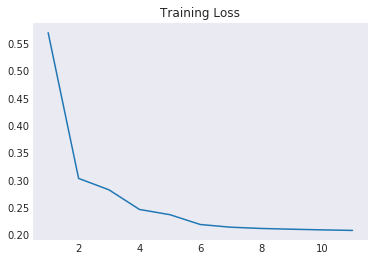

In [93]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'selected_features', labelCol = 'label', 
                        maxIter=10, regParam=0, elasticNetParam=0)
lrModel = lr.fit(train)
trainingSummary = lrModel.summary
g = sns.lineplot(x=range(1, len(trainingSummary.objectiveHistory) + 1), 
                 y=trainingSummary.objectiveHistory)
g.set_title('Training Loss')

In [94]:
fMeasure = trainingSummary.fMeasureByThreshold
maxFMeasure = fMeasure.groupBy().max('F-Measure').select('max(F-Measure)').head()
bestThreshold = fMeasure.where(fMeasure['F-Measure'] == maxFMeasure['max(F-Measure)']) \
                        .select('threshold').head()['threshold']
lr.setThreshold(bestThreshold)
predictions = lrModel.transform(test)
# predictions.show(10)

In [96]:
eval_lr_bm_raw = eval(lrModel, train, test, 'LR+BM Raw')

Model: LR+BM Raw
        Name   Data       ROC   LogLoss  F1-Score
0  LR+BM Raw  Train  0.962717  0.208049  0.812294
1  LR+BM Raw   Test  0.617494  0.902251  0.263471


### Gradient Boosted Trees

In [97]:
from pyspark.ml.classification import GBTClassifier
gb = GBTClassifier(featuresCol = 'selected_features', labelCol = 'label', 
                   maxIter = 20, seed = 8888)
gbModel = gb.fit(train)
eval_gbt_bm_raw = eval(gbModel, train, test, 'GBT+BM Raw')

Model: GBT+BM Raw
         Name   Data       ROC   LogLoss  F1-Score
0  GBT+BM Raw  Train  0.966866  0.219323  0.810052
1  GBT+BM Raw   Test  0.531103  0.727883  0.260219
